# Urban Simulation: Part 1

## Importing Packages

In [1]:
# we will import all the necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

## Creating the unweighted network

#### Pre-processing from Week 10 Practical

In [2]:
#tlf provides passenger flow data for each network separately
#we need to create a list of all the different files we need
files = ['NBT19MTT2b_od__DLR_tb_wf.csv', 
         'NBT19MTT2b_od__EZL_tb_wf.csv', 
         'NBT19MTT2b_od__LO_tb_wf.csv', 
         'NBT19MTT2b_od__LU_tb_wf.csv']

#create an empty list to store dataframes for each file
dfs = []

#iterate through our files list, read the file and append to our dataframe list
for file in files:
    dfs.append(pd.read_csv('data/' + file))
    
#merge all dataframes
london_OD = pd.concat(dfs, ignore_index=True)

In [3]:
#take a look at our data
london_OD.head()

,mode_mnlc_o,mode_mnlc_d,2,3,4,5,6,7,mode,1,8
0,504,523,8.033,16.430,24.563,28.555,13.023,2.263,DLR,NaN,NaN
1,504,533,30.719,40.105,61.571,57.881,15.573,0.317,DLR,NaN,NaN
2,504,538,5.941,17.238,37.493,43.158,33.890,10.429,DLR,NaN,NaN
3,504,559,5.795,26.397,27.285,24.065,15.213,8.508,DLR,NaN,NaN
4,504,573,77.786,113.750,143.938,387.562,165.776,65.283,DLR,NaN,NaN


In [4]:
definition_df = pd.read_excel('data/NBT19_Definitions.xlsx', 'Stations')
definition_df.head()

,MNLC,MASC,StationName,TFL?
0,500.0,ACTu,Acton Town,True
1,501.0,BARu,Barbican,True
2,502.0,ALDu,Aldgate,True
3,503.0,ALEu,Aldgate East,True
4,504.0,STId,Stratford International DLR,True


In [5]:
#we will drop any missing values from our dataframe
definition_df.dropna(inplace=True)

#transform mnlc codes from floats to int
definition_df.MNLC = definition_df.MNLC.astype(int)
definition_df.head()

,MNLC,MASC,StationName,TFL?
0,500,ACTu,Acton Town,True
1,501,BARu,Barbican,True
2,502,ALDu,Aldgate,True
3,503,ALEu,Aldgate East,True
4,504,STId,Stratford International DLR,True


In [6]:
#add the station names
london_OD['station_origin'] = london_OD['mode_mnlc_o'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])
london_OD['station_destination'] = london_OD['mode_mnlc_d'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])
london_OD.head()

,mode_mnlc_o,mode_mnlc_d,2,3,4,5,6,7,mode,1,8,station_origin,station_destination
0,504,523,8.033,16.430,24.563,28.555,13.023,2.263,DLR,NaN,NaN,Stratford International DLR,King George V
1,504,533,30.719,40.105,61.571,57.881,15.573,0.317,DLR,NaN,NaN,Stratford International DLR,London City Airport
2,504,538,5.941,17.238,37.493,43.158,33.890,10.429,DLR,NaN,NaN,Stratford International DLR,Pontoon Dock
3,504,559,5.795,26.397,27.285,24.065,15.213,8.508,DLR,NaN,NaN,Stratford International DLR,West Silvertown
4,504,573,77.786,113.750,143.938,387.562,165.776,65.283,DLR,NaN,NaN,Stratford International DLR,Woolwich Arsenal


In [7]:
# we will only keep passenger flows for the timeband we are interested in
london_OD_AMpeak = london_OD[['station_origin', 'station_destination', '3']].copy()
london_OD_AMpeak.head()

,station_origin,station_destination,3
0,Stratford International DLR,King George V,16.430
1,Stratford International DLR,London City Airport,40.105
2,Stratford International DLR,Pontoon Dock,17.238
3,Stratford International DLR,West Silvertown,26.397
4,Stratford International DLR,Woolwich Arsenal,113.750


In [8]:
#rename column
london_OD_AMpeak.rename({'3':'flows'}, axis=1, inplace=True)

#since the flows are averages the are stored as flows.
#for our analysis we will turn the into ints
london_OD_AMpeak.flows = london_OD_AMpeak.flows.astype(int)
london_OD_AMpeak.head()

,station_origin,station_destination,flows
0,Stratford International DLR,King George V,16
1,Stratford International DLR,London City Airport,40
2,Stratford International DLR,Pontoon Dock,17
3,Stratford International DLR,West Silvertown,26
4,Stratford International DLR,Woolwich Arsenal,113


Let's get all the station names

In [9]:
station_origin = list(london_OD_AMpeak.station_origin.values)
station_destination = list(london_OD_AMpeak.station_destination.values)
all_stations = list(set(station_origin + station_destination))
all_stations = sorted(all_stations, key=str.lower)

In [10]:
all_stations

['Abbey Road',
 'Acton Central',
 'Acton Main Line',
 'Acton Town',
 'Aldgate',
 'Aldgate East',
 'All Saints',
 'Alperton',
 'Amersham',
 'Anerley',
 'Angel',
 'Archway',
 'Arnos Grove',
 'Arsenal',
 'Baker Street',
 'Balham LU',
 'Bank and Monument',
 'Barbican',
 'Barking',
 'Barkingside',
 'Barons Court',
 'Battersea Park',
 'Bayswater',
 'Beckton',
 'Beckton Park',
 'Becontree',
 'Belsize Park',
 'Bermondsey',
 'Bethnal Green LO',
 'Bethnal Green LU',
 'Blackfriars LU',
 'Blackhorse Road',
 'Blackwall',
 'Bond Street',
 'Borough',
 'Boston Manor',
 'Bounds Green',
 'Bow Church',
 'Bow Road',
 'Brent Cross',
 'Brentwood',
 'Brixton LU',
 'Brockley',
 'Bromley-by-Bow',
 'Brondesbury',
 'Brondesbury Park',
 'Bruce Grove',
 'Buckhurst Hill',
 'Burnt Oak',
 'Bush Hill Park',
 'Bushey',
 'Caledonian Road',
 'Caledonian Road & Barnsbury',
 'Cambridge Heath',
 'Camden Road',
 'Camden Town',
 'Canada Water',
 'Canary Wharf DLR',
 'Canary Wharf LU',
 'Canning Town',
 'Cannon Street LU',
 'C

In [11]:
london_OD_AMpeak['station_origin']= london_OD_AMpeak.station_origin.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )
london_OD_AMpeak['station_destination']=london_OD_AMpeak.station_destination.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )

now we will sum the flows of stations with the same origin-destination name

In [12]:
#group by origin and destination station and sum the flows
london_OD_AMpeak = london_OD_AMpeak.groupby(['station_origin', 'station_destination'], as_index=False).sum()

In [13]:
london_OD_AMpeak.head()

,station_origin,station_destination,flows
0,Abbey Road,Bank and Monument,0
1,Abbey Road,Beckton,1
2,Abbey Road,Blackwall,3
3,Abbey Road,Canary Wharf,1
4,Abbey Road,Canning Town,37


In [14]:
#let's sanity check and see the highest and lowest flows in and out flows
outflows = london_OD_AMpeak.groupby('station_origin', as_index=False).sum()

In [15]:
outflows.sort_values('flows').head(10)

,station_origin,station_destination,flows
21,Battersea Park,BrockleyCanada WaterClapham High StreetDalston...,0
385,West India Quay,All SaintsBank and MonumentBecktonBlackwallBow...,162
68,Cheshunt,BarkingBethnal GreenBruce GroveCambridge Heath...,171
49,Bushey,Acton CentralBarkingBrondesburyCarpenders Park...,238
167,Heathrow Terminals 2 & 3 EL,Ealing BroadwayHanwellHayes & HarlingtonHeathr...,242
307,South Hampstead,Acton CentralBusheyCarpenders ParkEustonGunner...,248
298,Shenfield,BrentwoodChadwell HeathForest GateGidea ParkGo...,248
186,Hyde Park Corner,Acton TownAldgateAldgate EastAlpertonAmershamA...,259
24,Beckton Park,Bank and MonumentBecktonBlackwallBow ChurchCan...,293
52,Cambridge Heath,Bethnal GreenBruce GroveBush Hill ParkCaledoni...,328


In [16]:
outflows.sort_values('flows').tail(10)

,station_origin,station_destination,flows
258,Paddington,Acton Main LineActon TownAldgateAldgate EastAl...,24071
125,Finsbury Park,Acton TownAldgateAldgate EastAlpertonAmershamA...,24735
55,Canada Water,Acton CentralActon TownAlpertonAmershamAnerley...,27026
203,King's Cross St. Pancras,Acton TownAldgateAldgate EastAlpertonAmershamA...,28307
16,Bank and Monument,Abbey RoadActon TownAldgateAldgate EastAll Sai...,29494
218,Liverpool Street,Acton TownAldgateAldgate EastAlpertonAmershamA...,31473
219,London Bridge,Acton TownAldgateAldgate EastAlpertonAmershamA...,32597
362,Victoria,Acton TownAldgateAldgate EastAlpertonAmershamA...,37517
333,Stratford,Abbey RoadActon CentralActon TownAldgateAldgat...,59311
371,Waterloo,Acton TownAldgateAldgate EastAlpertonAmershamA...,67372


In [17]:
#let's sanity check and see the highest and lowest flows in and out flows
inflows = london_OD_AMpeak.groupby('station_destination', as_index=False).sum()

In [18]:
inflows.sort_values('flows').head(10)

,station_destination,station_origin,flows
21,Battersea Park,BrockleyCanada WaterClapham High StreetDalston...,0
115,Emerson Park,RomfordUpminster,42
2,Acton Main Line,Ealing BroadwayHayes & HarlingtonPaddingtonSou...,70
153,Hanwell,Ealing BroadwayHayes & HarlingtonHeathrow Term...,72
138,Grange Hill,Aldgate EastAngelBaker StreetBalhamBank and Mo...,76
285,Roding Valley,Aldgate EastAngelBank and MonumentBarbicanBark...,84
24,Beckton Park,Bank and MonumentBecktonBlackwallBow ChurchCan...,88
381,West Finchley,AldgateAldgate EastAngelArchwayBaker StreetBal...,91
159,Hatch End,Acton CentralBusheyCamden RoadCarpenders ParkC...,93
343,Theydon Bois,Aldgate EastAngelBank and MonumentBarbicanBark...,98


In [19]:
inflows.sort_values('flows').tail(10)

,station_destination,station_origin,flows
121,Farringdon,Acton TownAldgateAldgate EastAlpertonAmershamA...,25592
140,Green Park,Acton TownAldgateAldgate EastAlpertonAmershamA...,26754
219,London Bridge,Acton TownAldgateAldgate EastAlpertonAmershamA...,29930
362,Victoria,Acton TownAldgateAldgate EastAlpertonAmershamA...,33251
203,King's Cross St. Pancras,Acton TownAldgateAldgate EastAlpertonAmershamA...,33330
257,Oxford Circus,Acton TownAldgateAldgate EastAlpertonAmershamA...,44368
333,Stratford,Abbey RoadActon CentralActon TownAldgateAldgat...,55954
56,Canary Wharf,Abbey RoadActon TownAldgateAldgate EastAll Sai...,58772
218,Liverpool Street,Acton TownAldgateAldgate EastAlpertonAmershamA...,61122
16,Bank and Monument,Abbey RoadActon TownAldgateAldgate EastAll Sai...,78549


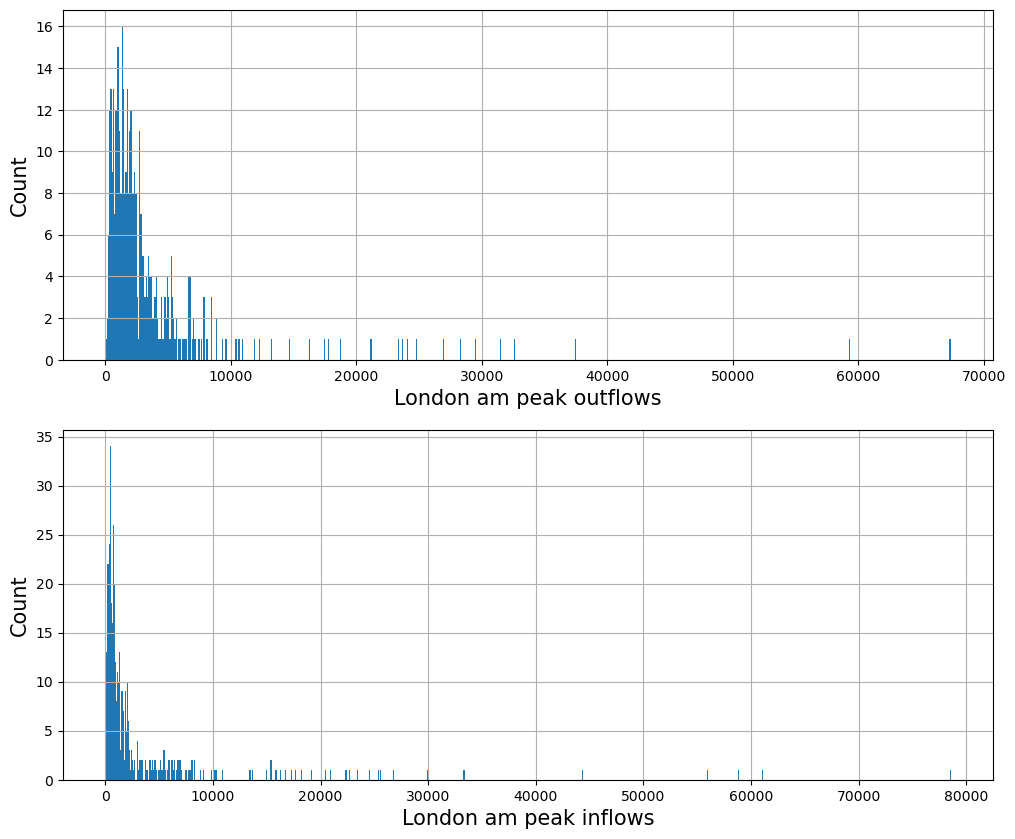

In [20]:
#let's plot this as a histogram
bin_size=100
fig, ax = plt.subplots(2,1,figsize=(12,10))
ax[0].hist(outflows['flows'], bins=int(outflows['flows'].max()/bin_size))
ax[0].set_xlabel('London am peak outflows', fontsize = 15)
ax[0].set_ylabel("Count", fontsize= 15)
ax[0].grid(True)

ax[1].hist(inflows['flows'], bins=int(inflows['flows'].max()/bin_size))
ax[1].set_xlabel('London am peak inflows', fontsize = 15)
ax[1].set_ylabel("Count", fontsize= 15)
ax[1].grid(True)
plt.show()

### Load London Underground shapefile data

In [21]:
#read in the data using geopandas
stations = gpd.read_file('data/tfl_stations.json')
lines = gpd.read_file('data/tfl_lines.json')

In [22]:
#project data to British National Grid
#we do this so we can work in meters
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)

### Stations file

In [23]:
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           529 non-null    object  
 1   name         529 non-null    object  
 2   nlc_id       518 non-null    object  
 3   lines        529 non-null    object  
 4   cartography  529 non-null    object  
 5   altmodeid    16 non-null     object  
 6   alt_id       337 non-null    object  
 7   altmodeid2   2 non-null      object  
 8   zone         529 non-null    object  
 9   geometry     529 non-null    geometry
dtypes: geometry(1), object(9)
memory usage: 41.5+ KB


In [24]:
stations.head()

,id,name,nlc_id,lines,cartography,altmodeid,alt_id,altmodeid2,zone,geometry
0,940GZZLUACT,Acton Town,0500,"[ { ""name"": ""District"" }, { ""name"": ""Piccadill...",{'labelX': 30},NaN,1,NaN,3,POINT (519484.905 179592.101)
1,940GZZLUACY,Archway,0508,"[ { ""name"": ""Northern"", ""nightopened"": 2016 } ]",{'labelX': -30},NaN,8,NaN,2/3,POINT (529382.416 186814.396)
2,940GZZLUADE,Aldgate East,0503,"[ { ""name"": ""District"" }, { ""name"": ""Hammersmi...",{'labelX': 30},NaN,3,NaN,1,POINT (533886.853 181342.360)
3,940GZZLUAGL,Angel,0507,"[ { ""name"": ""Northern"" }, { ""name"": ""Crossrail...","{'labelX': 1, 'labelY': -35}",NaN,7,NaN,1,POINT (531462.253 183134.536)
4,940GZZLUALD,Aldgate,0502,"[ { ""name"": ""Circle"" }, { ""name"": ""Metropolita...","{'labelX': 25, 'labelY': 20}",NaN,2,NaN,1,POINT (533623.564 181218.497)


<Axes: >

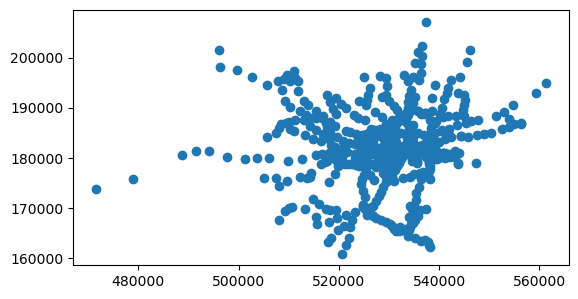

In [25]:
stations.plot()

### Clean station names

We have multiple points representing one station (for example Paddington has seperate points for different entrances). We will simplify this by using RegEx make the names consistent. 

Once we have cleaned the names we can set the coordinate of these stations to the mean values of the coordinates of all the stations with the same name.

In [26]:
#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

In [27]:
#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])

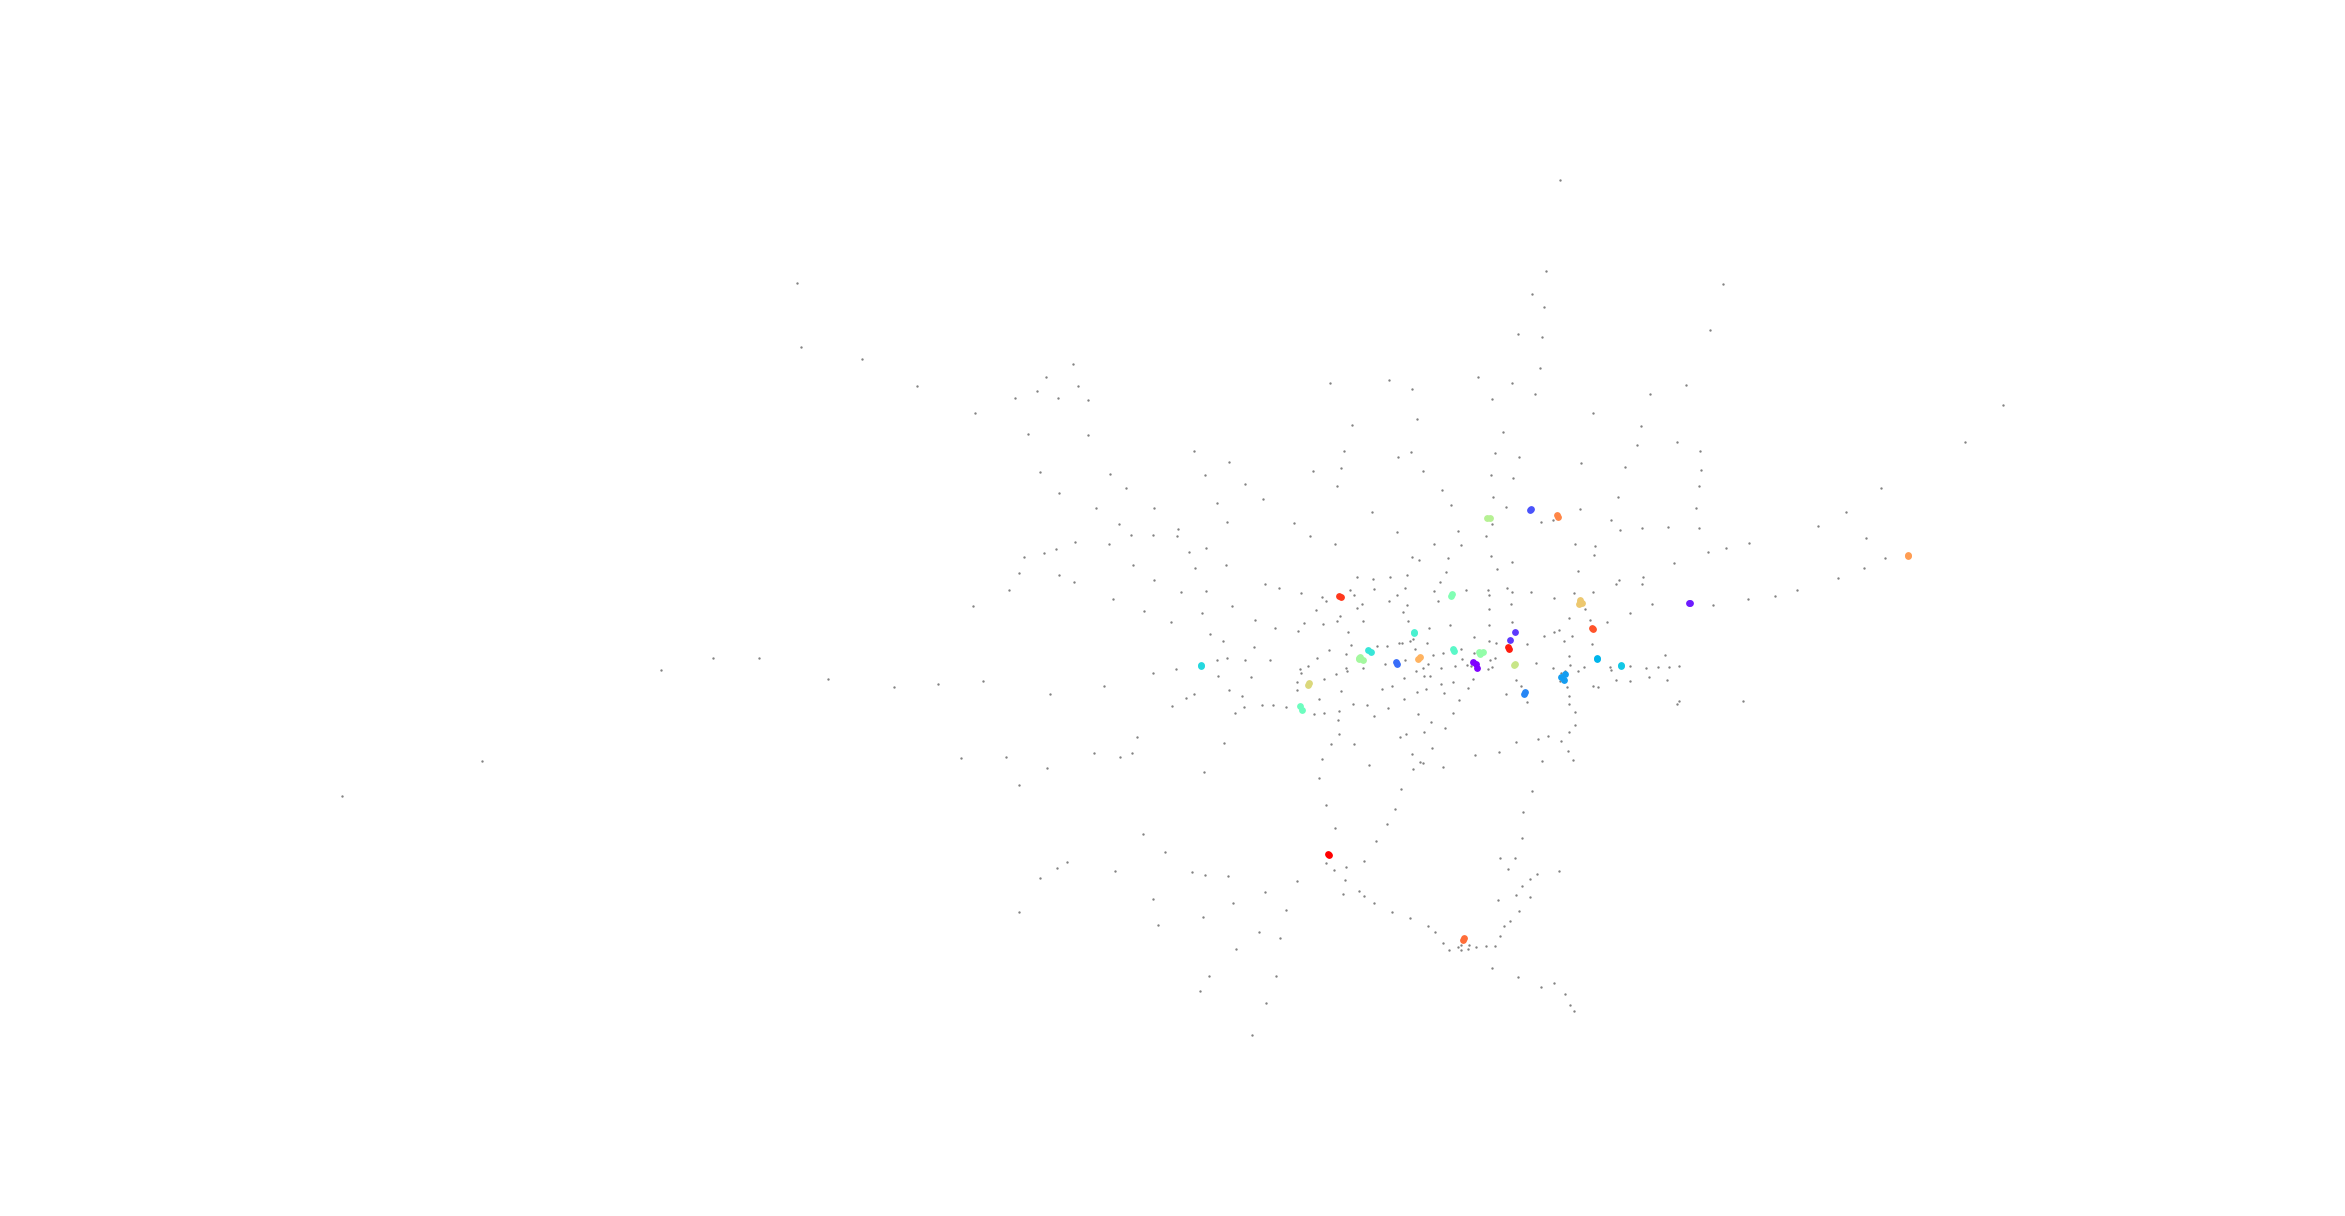

In [28]:
## we will plot all the stations with multiple points to check there are no errors
fig, ax = plt.subplots(figsize = (30,30))
ax.set_aspect("equal")
ax.axis('off')
ax.margins(0.2)
color = iter(cm.rainbow(np.linspace(0, 1, 29)))
stations.plot(ax=ax, color='grey', markersize=0.5)
for i, group in stations.groupby('name'):
    if len(group)>1:
        group.plot(ax=ax, color = next(color), markersize=15)
plt.show()

**Change position of station to mean of all station with the same name**

In [29]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

In [30]:
#set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))

<Axes: >

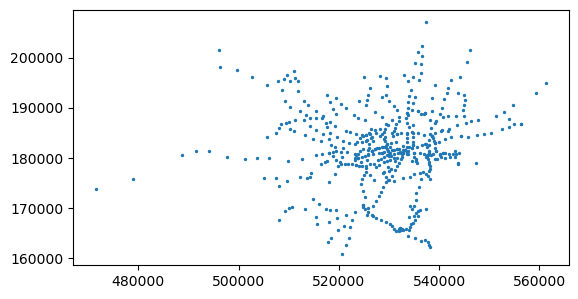

In [31]:
#check plot to make sure there are no errors
stations.plot(markersize=2)

### Lines file

In [32]:
lines.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        701 non-null    object  
 1   lines     701 non-null    object  
 2   geometry  701 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 16.6+ KB


In [33]:
lines.head()

,id,lines,geometry
0,LeaValleyLine1,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (534726.021 182339.910, 534747.550 ..."
1,LeaValleyLine2,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (534826.495 183293.130, 534820.978 ..."
2,LeaValleyLine3,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (534783.192 184262.624, 534785.835 ..."
3,LeaValleyLine4,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (534530.346 185136.490, 534525.951 ..."
4,LeaValleyLine5,"[ { ""name"": ""London Overground"", ""opened"": 201...","LINESTRING (533996.588 186186.930, 533979.709 ..."


<Axes: >

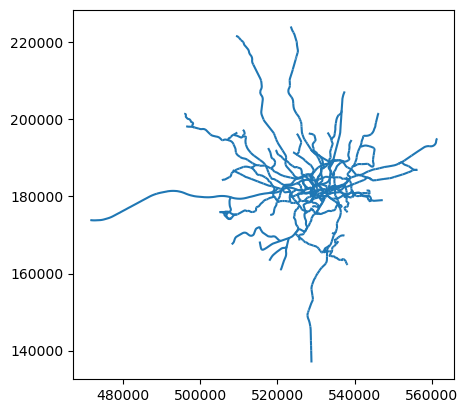

In [34]:
lines.plot()

### Get all line names

We can see from our lines geodataframe that one geometry can represent multiple lines (for example one for the circle line and another for hammersmith and city) that go between the same stations. 

Let's work each line seperately to make cleaning and checking the data easier. 

In [35]:
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names

['Jubilee',
 'Central',
 'Tramlink',
 'Northern',
 'Victoria',
 'Crossrail 2',
 'Crossrail',
 'Thameslink 6tph line',
 'Metropolitan',
 'East London',
 'Bakerloo',
 'TfL Rail',
 'District',
 'Circle',
 'DLR',
 'Hammersmith & City',
 'London Overground',
 'Emirates Air Line',
 'Piccadilly',
 'Waterloo & City']

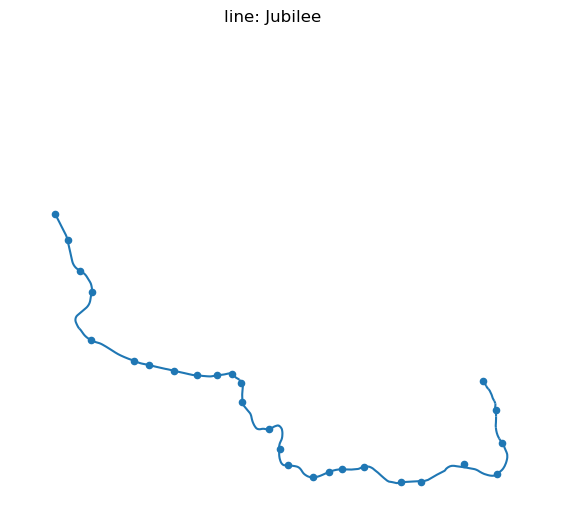

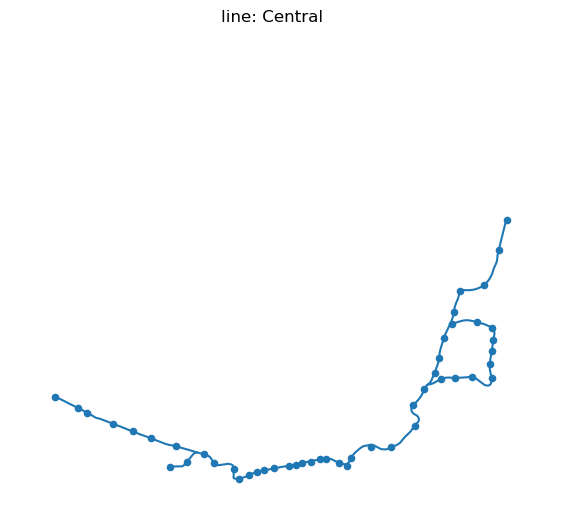

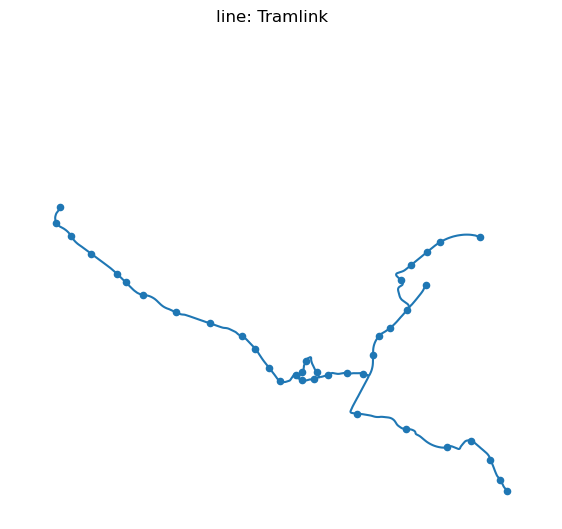

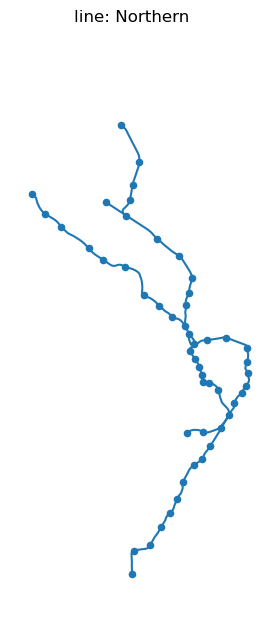

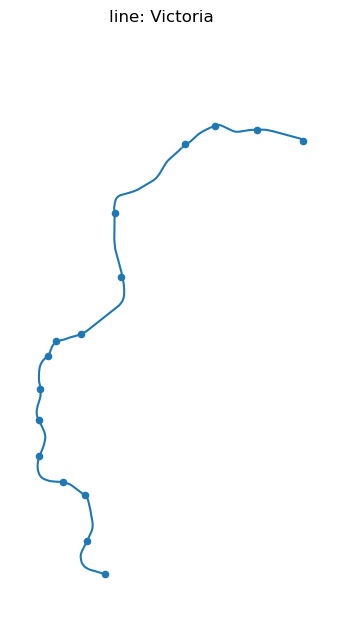

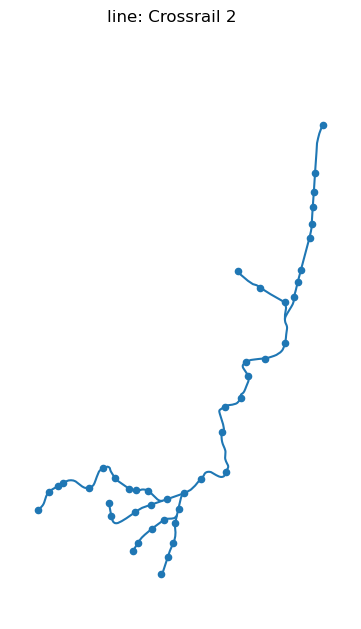

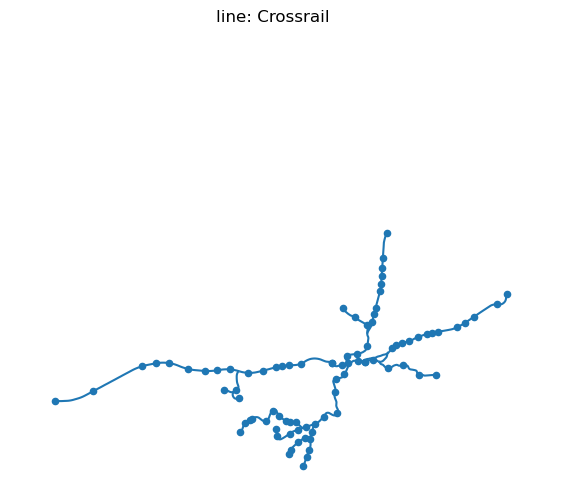

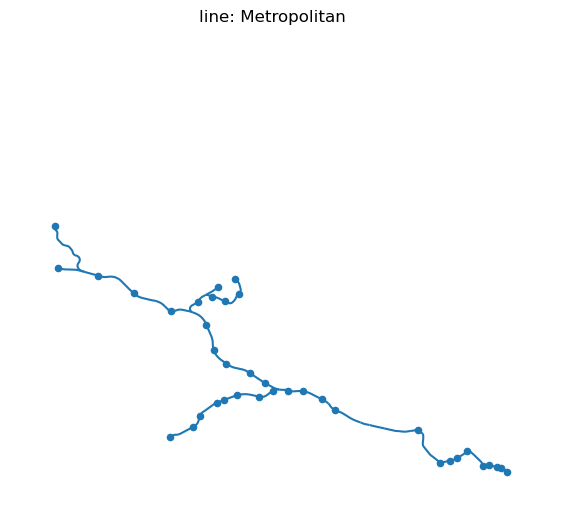

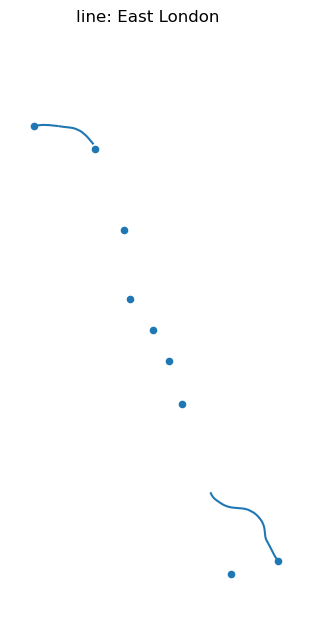

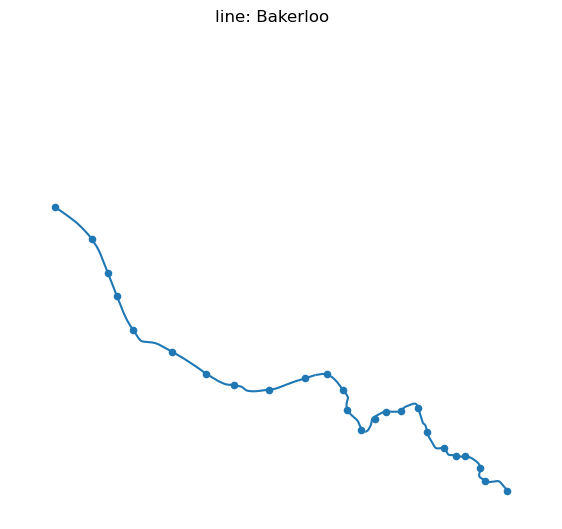

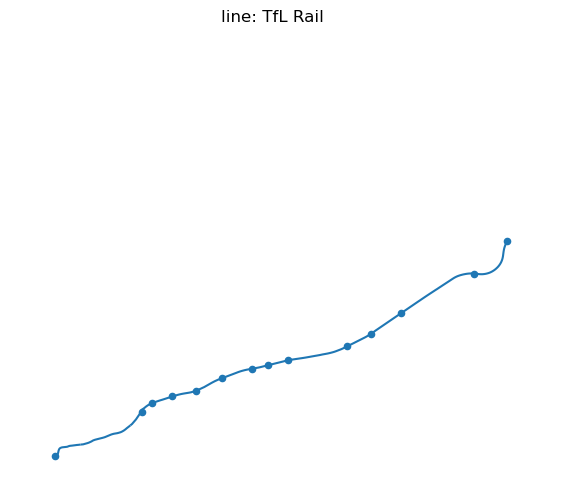

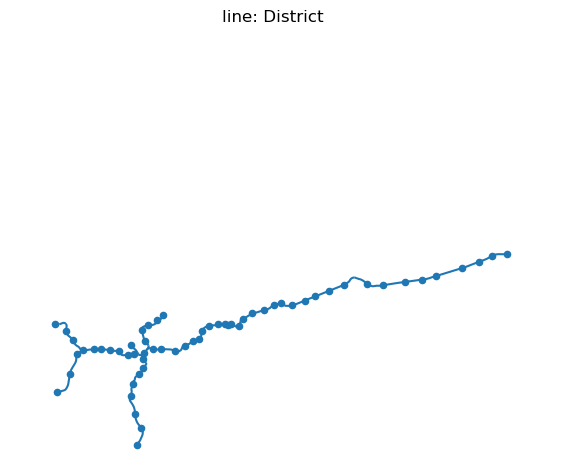

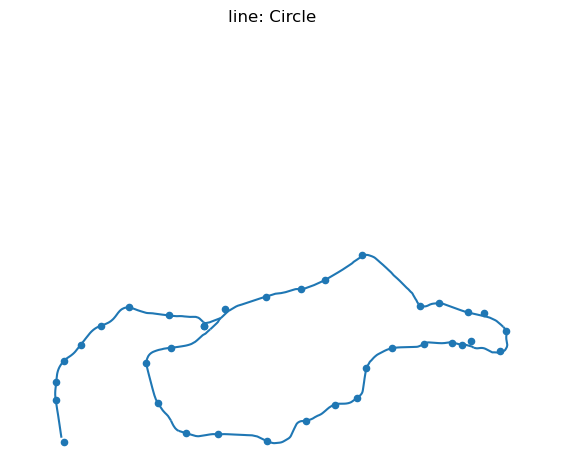

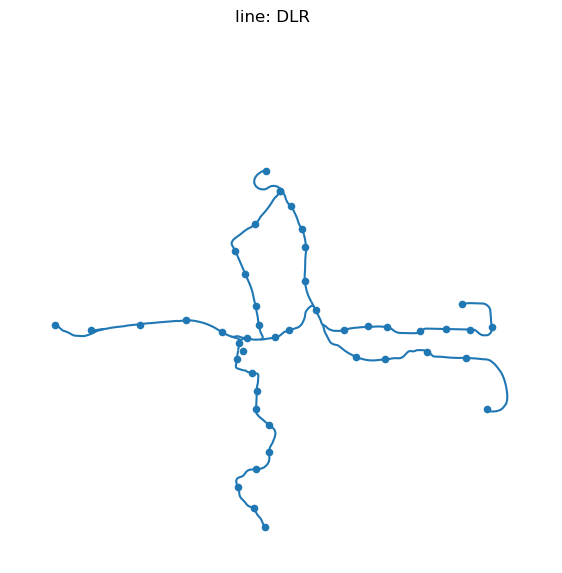

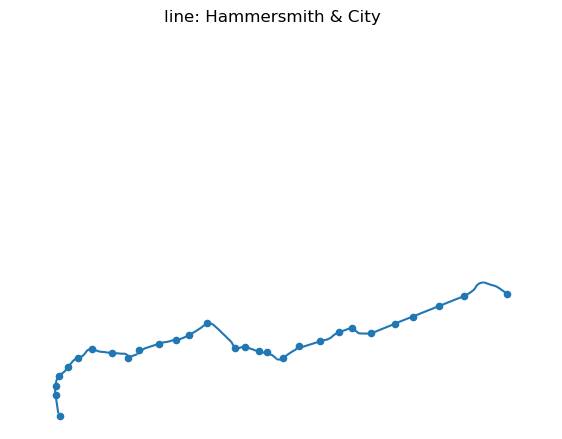

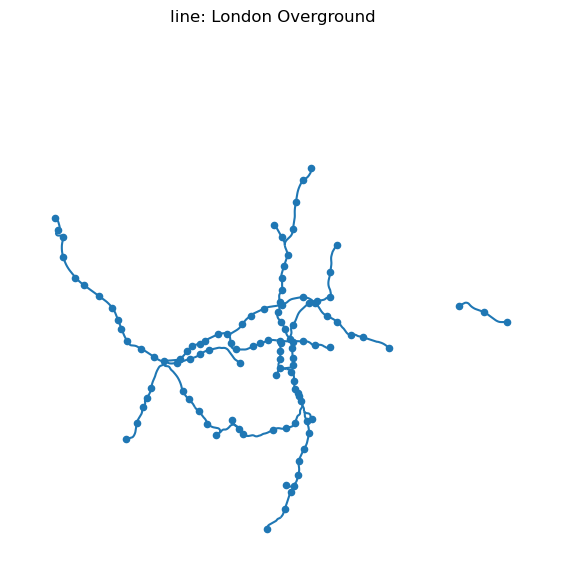

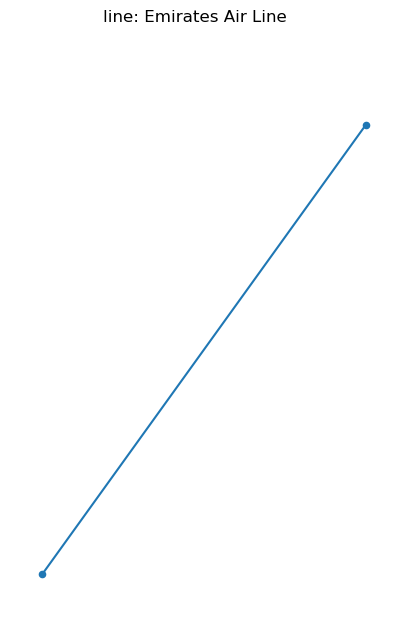

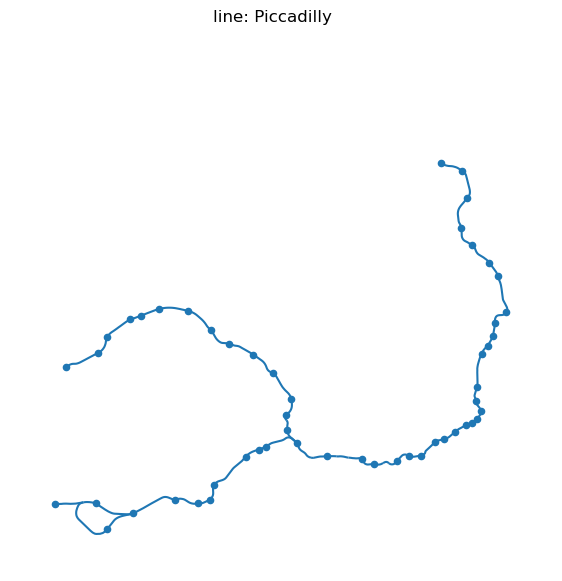

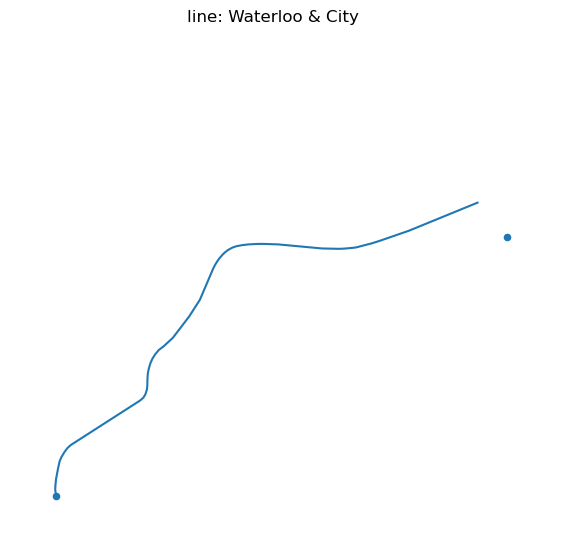

In [36]:
# check the data for each line
for line in line_names:
    #I'm removing thameslink 6tph line because there are not corresponding stations in station file
    if line == 'Thameslink 6tph line':
        continue
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    temp_lines = lines[lines.lines.str.contains(line)]
    base = temp_lines.plot(ax=ax)
    temp_stations = stations[stations.lines.str.contains(line)]
    temp_stations.plot(ax=base, markersize=20)
    plt.show()

In [37]:
#We can see that east london line is incomplete
#digging into this however we notice that it's because east london is actually part of the overground
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')

In [38]:
#Our TFL data doesn't include tramlink, emirates air lines, and crossrail is still in construction (except not really)
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']

## Create seperate graphs for each line and then join

Since we don't have properly constructed line geometries because:
* there are discontinuities in the line geometries
* a line between two stations can actually be composed of more than one geometry

We will construct geometric graphs (meaning graphs just from the line geometries where nodes are coordinates that define the line geometry). It's easy to fix the discontinuities in this manner because the can be thought of as nodes with degree = 1 that have another node with degree = 1 within a threshold distance. 

Once we have these discontinuties fixed we can use these geometric graphs to construct proper geometries between stations by taking the shortest paths within these networks starting from the node closest to the origin station and ending in the node closest to the destination station. The shortest path will then be a list of coordinates that define the line geometry between the two stations. 

Jubilee


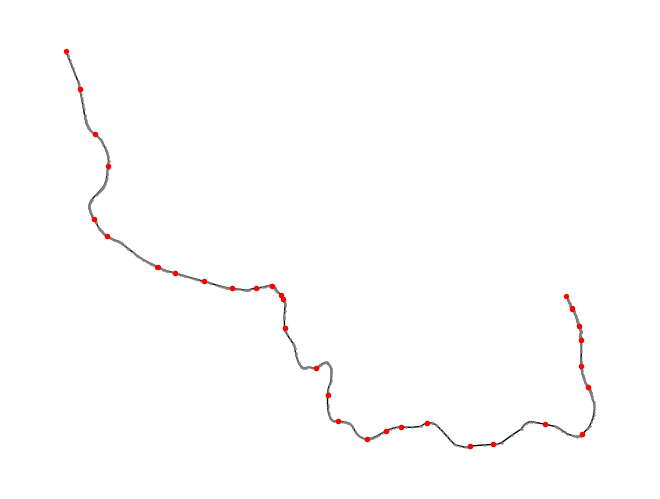

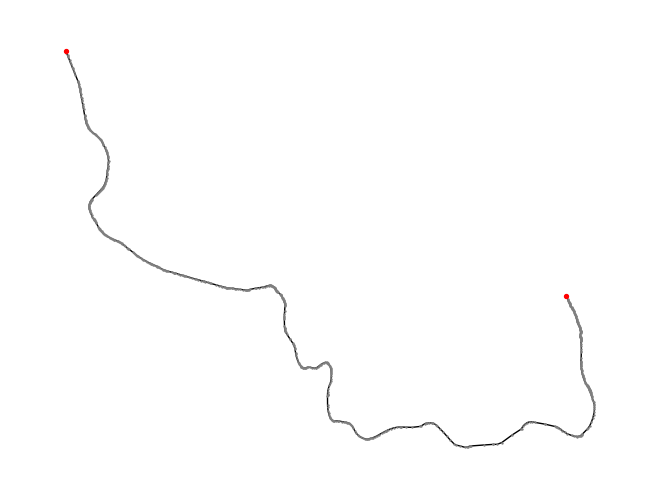

1
Central


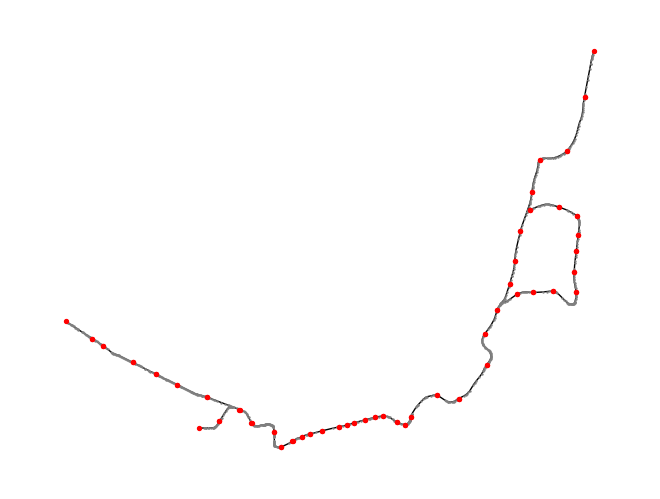

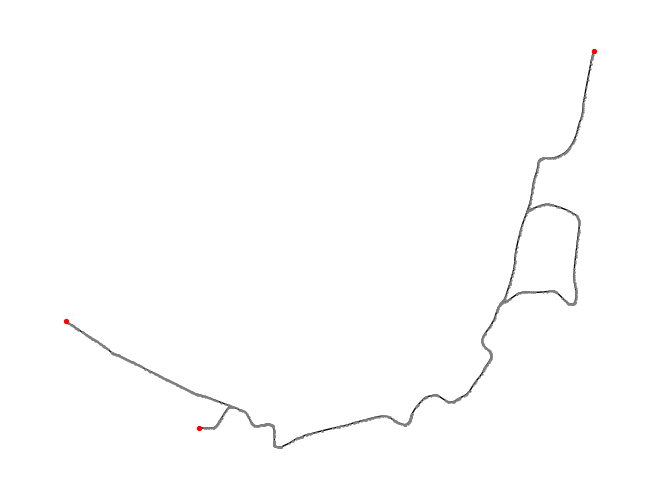

1
Northern


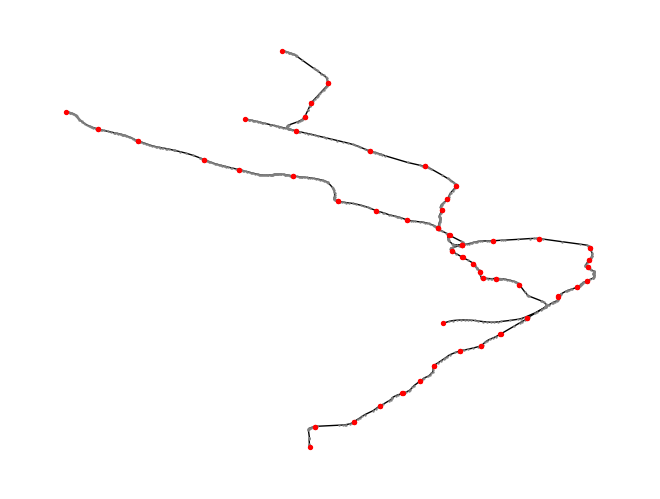

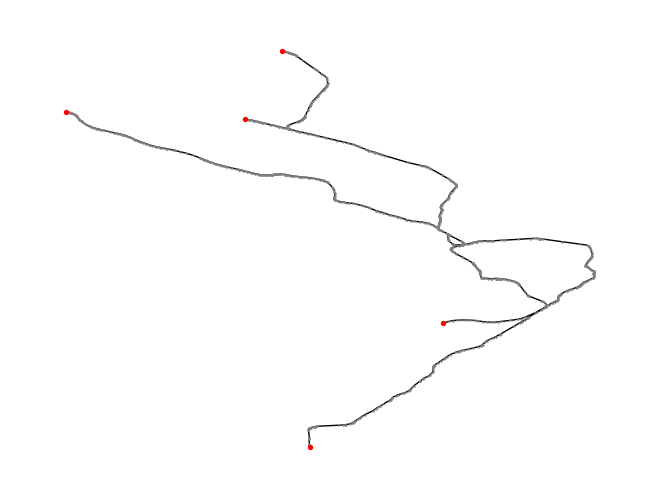

1
Victoria


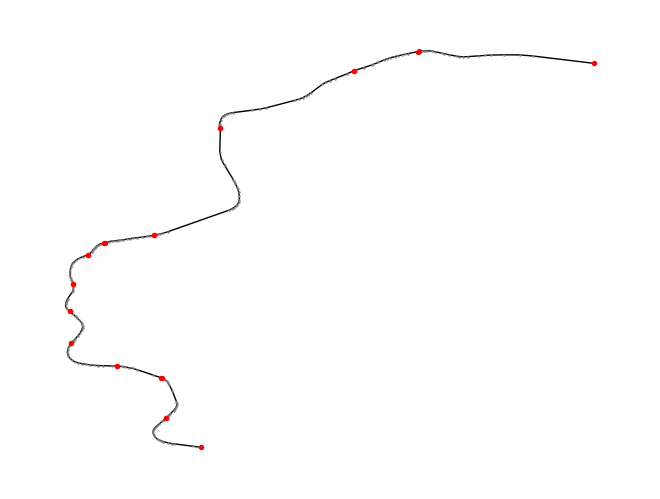

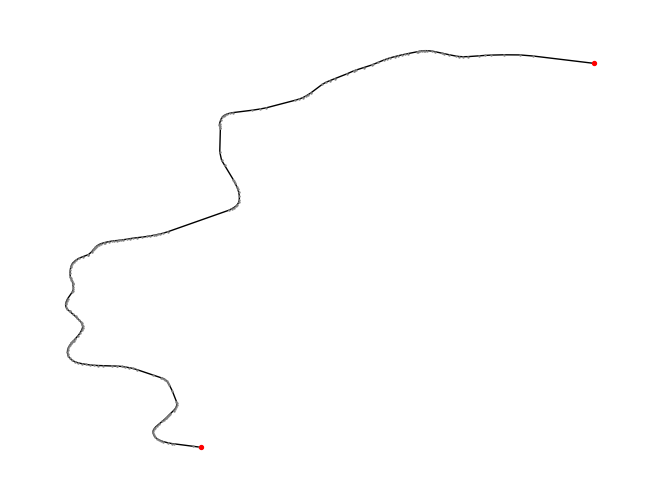

1
Metropolitan


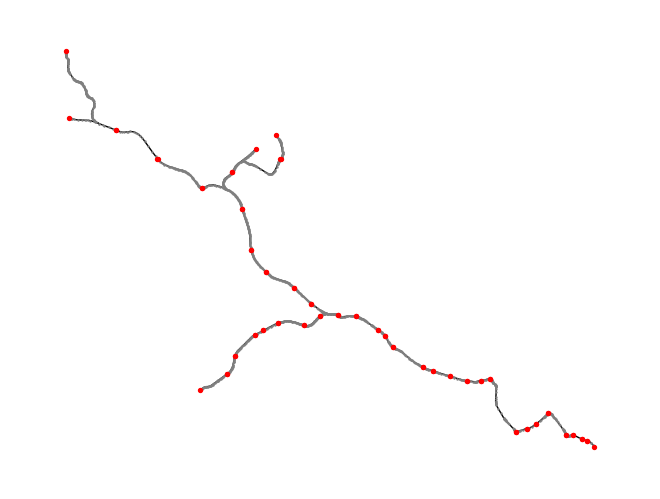

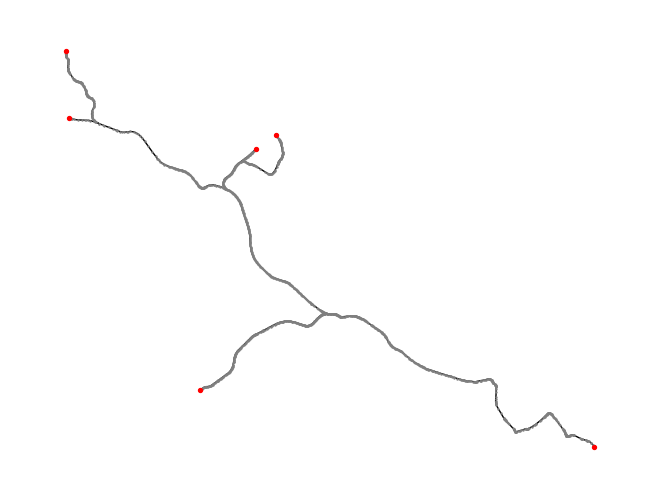

1
Bakerloo


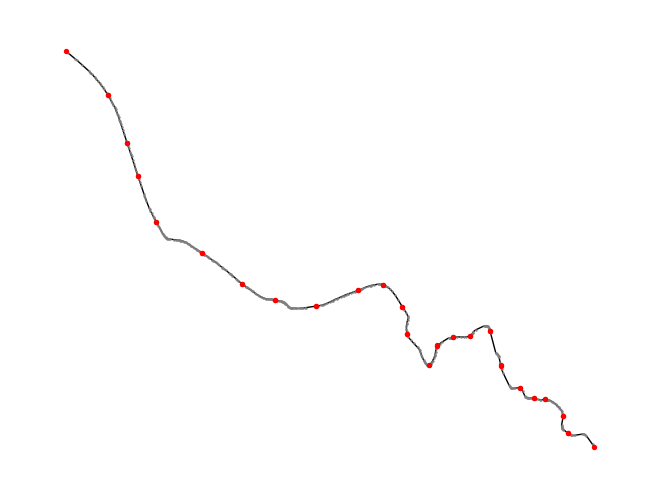

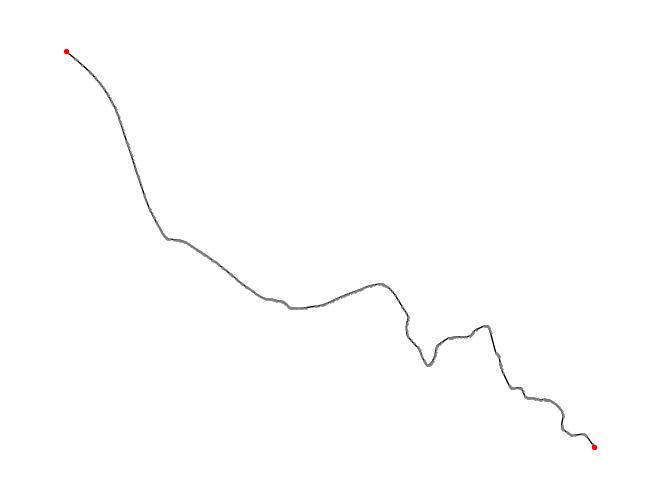

1
TfL Rail


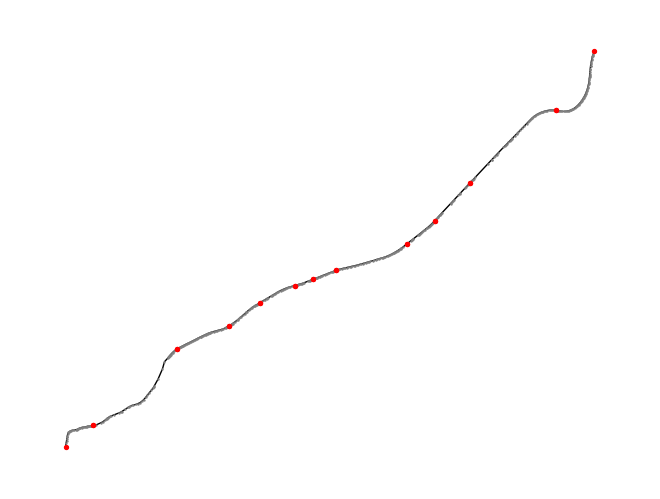

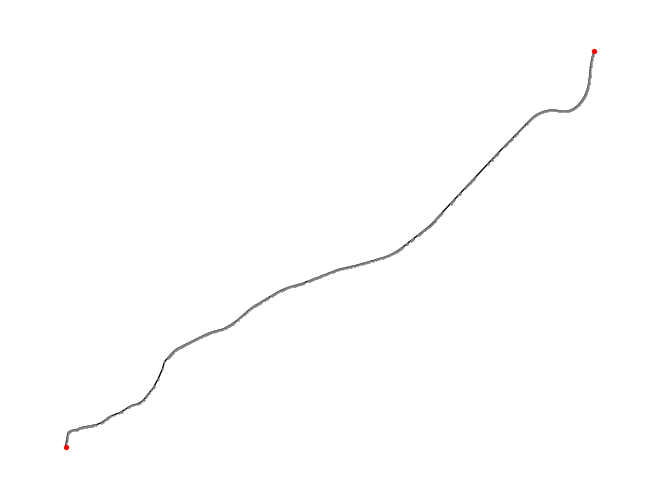

1
District


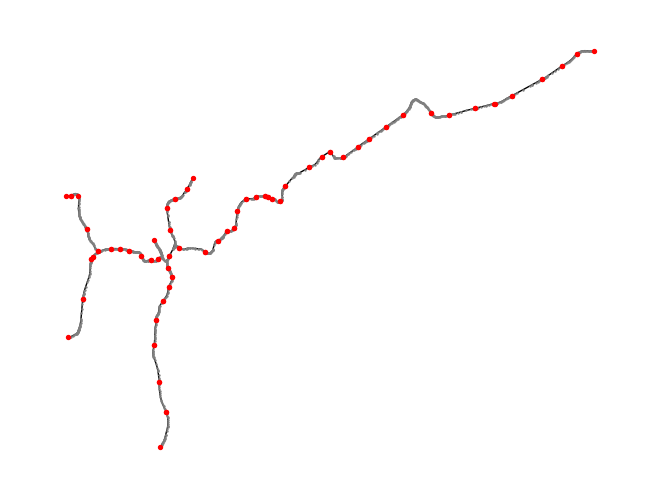

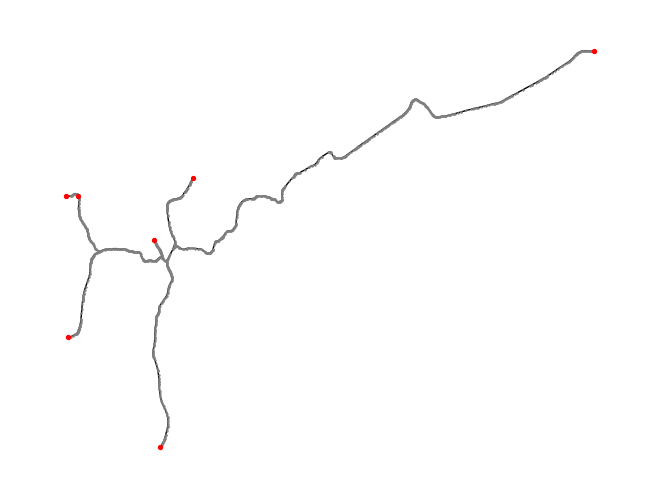

1
Circle


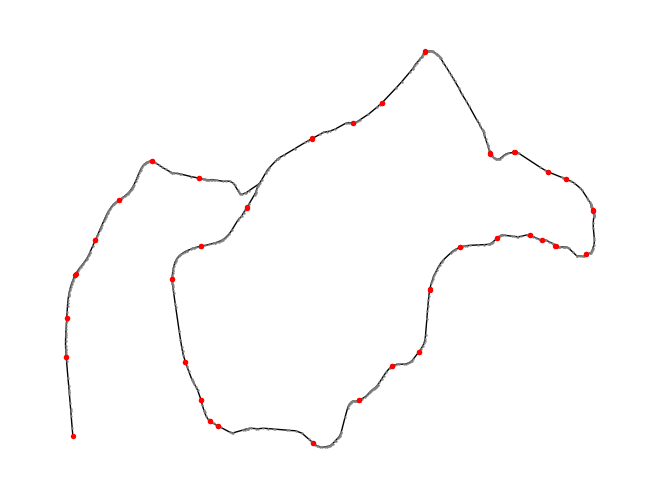

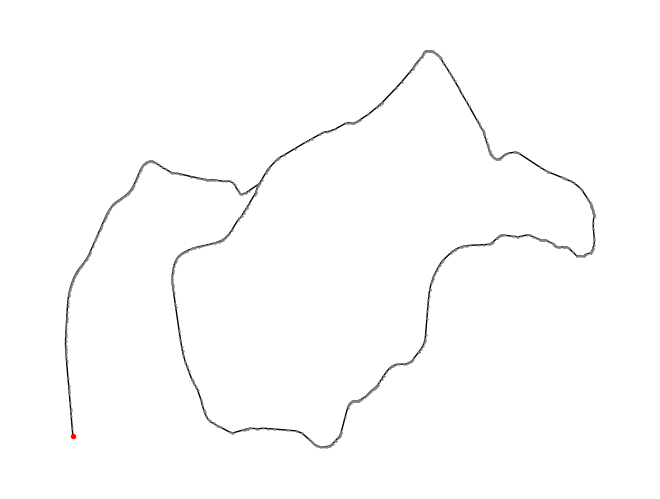

1
DLR


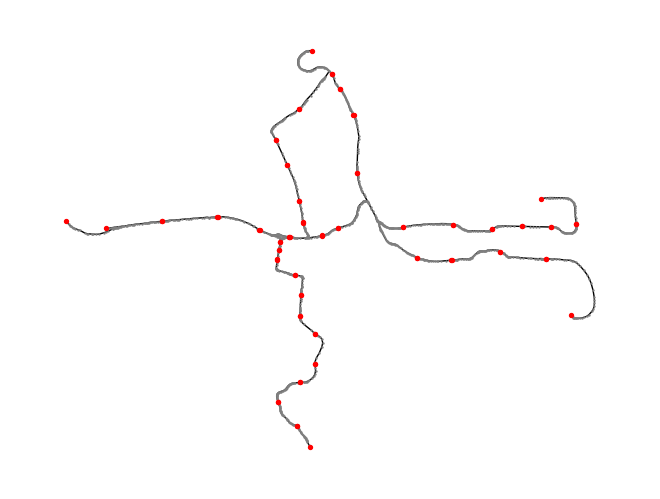

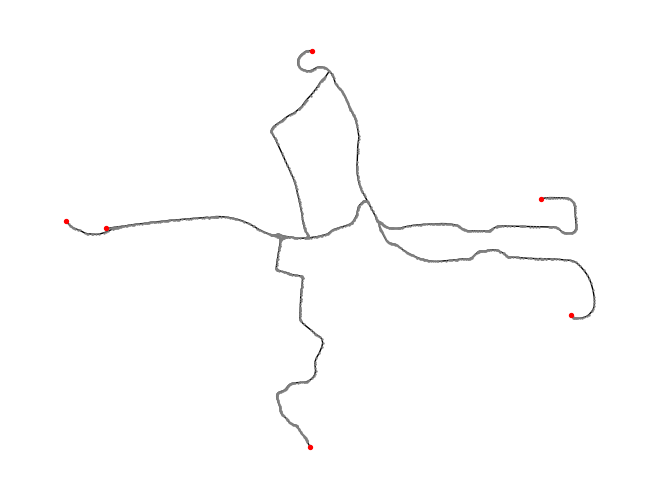

1
Hammersmith & City


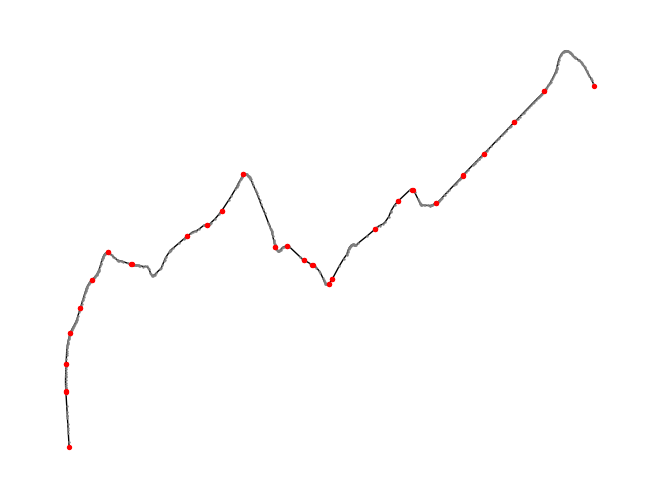

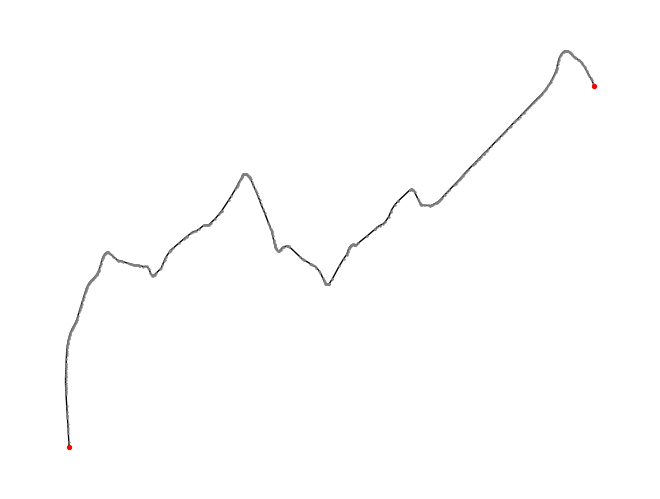

1
London Overground


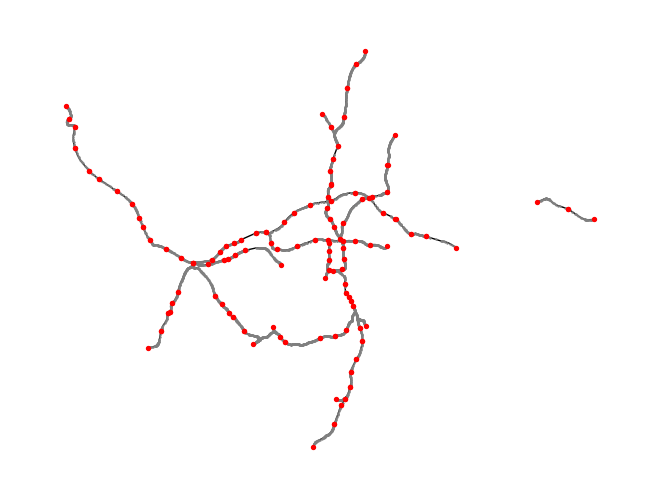

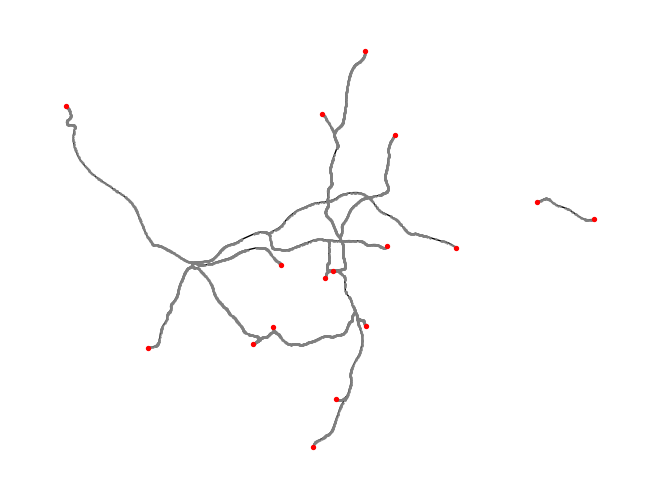

3
Piccadilly


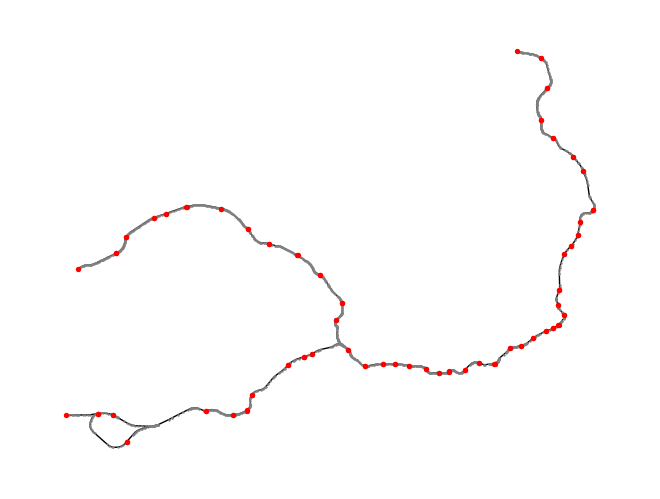

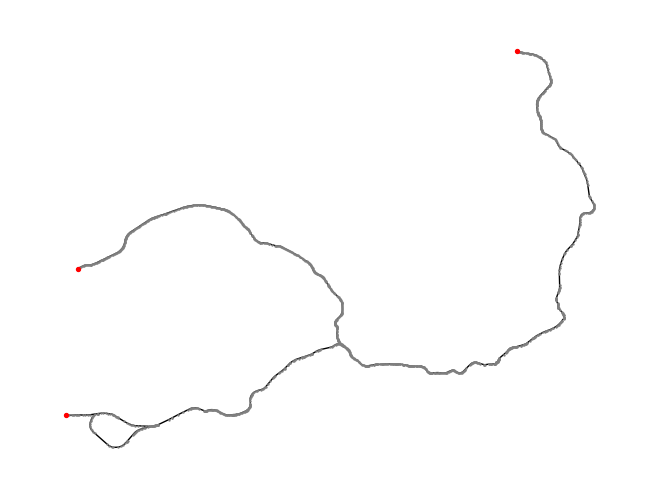

1
Waterloo & City


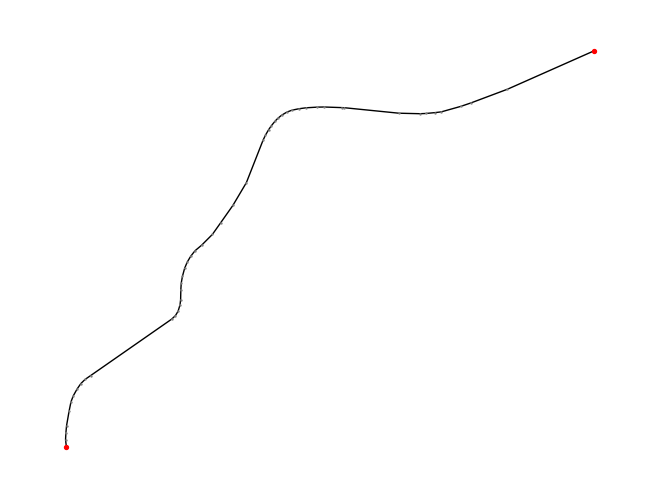

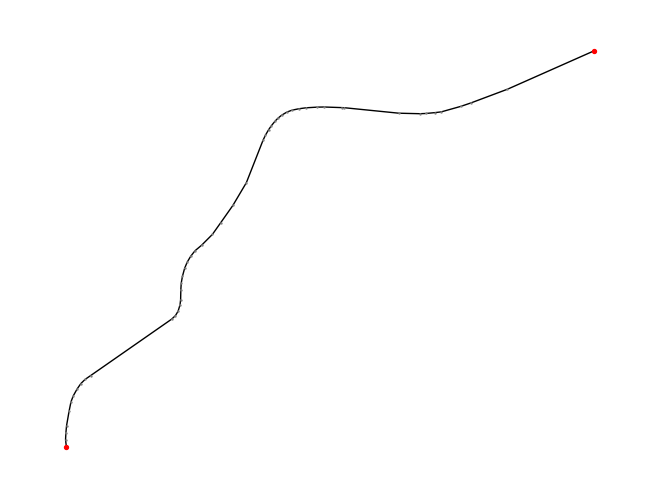

1


In [39]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G


Now that we have these geometric graphs we can create our final graph by using the data in the lines attribute in our lines geodataframe that contains origin and destination station. We can then use our geometric graph and find the shortest route to create our line geometries and find the length of the lines. 

We will store this information in a dataframe that we can use to create our final graph

In [40]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })

,line_name,start_id,end_id,geometry
0,Jubilee,940GZZLUWYP,940GZZLUKBY,"LINESTRING (519316.559 186389.330, 519359.969 ..."
1,Jubilee,940GZZLUKBY,940GZZLUQBY,"LINESTRING (519359.969 188721.220, 518811.361 ..."
2,Jubilee,940GZZLUQBY,940GZZLUCPK,"LINESTRING (518811.361 189760.507, 518183.300 ..."
3,Jubilee,940GZZLUCPK,940GZZLUSTM,"LINESTRING (518183.300 191257.263, 517580.460 ..."
4,Jubilee,940GZZLUSTD,940GZZLUWHM,"LINESTRING (538524.786 184373.341, 539160.258 ..."


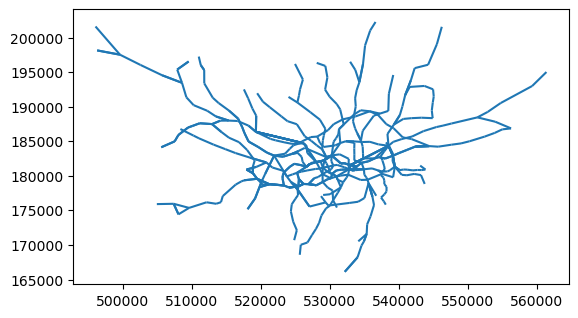

In [41]:
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs
edge_gdf.plot()
edge_gdf.head()

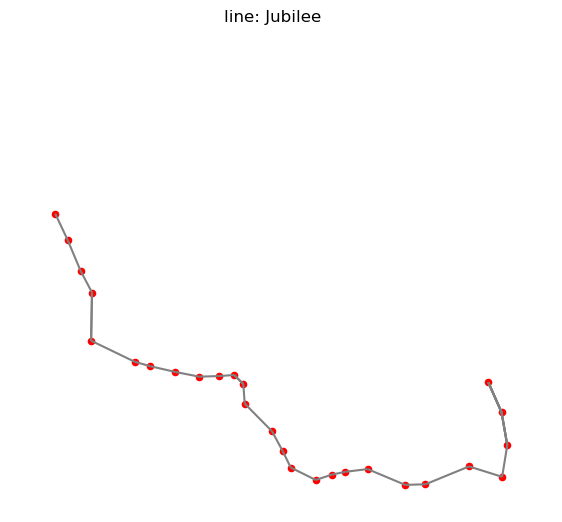

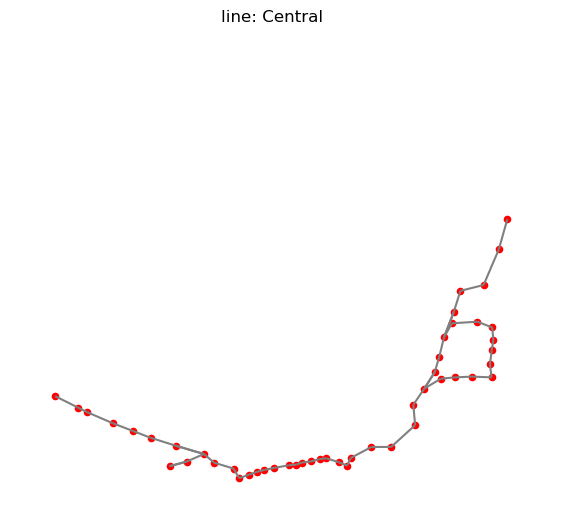

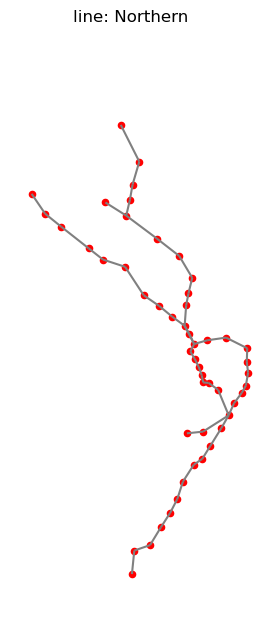

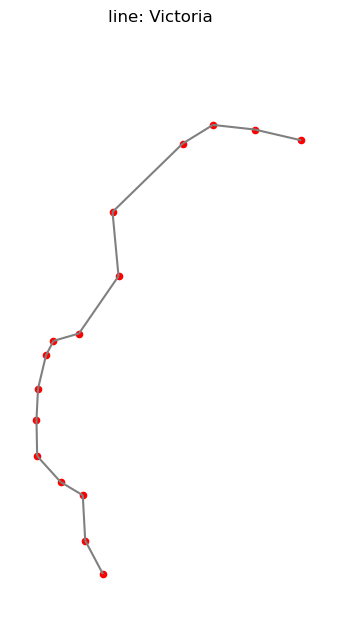

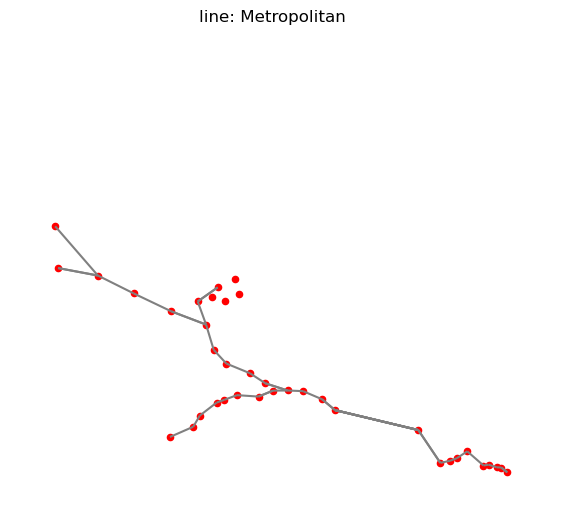

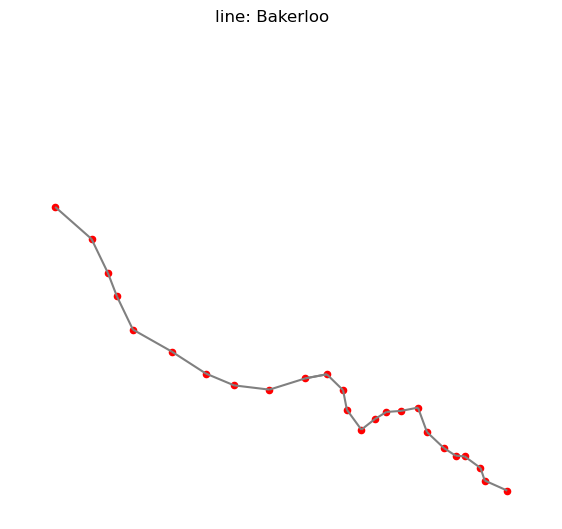

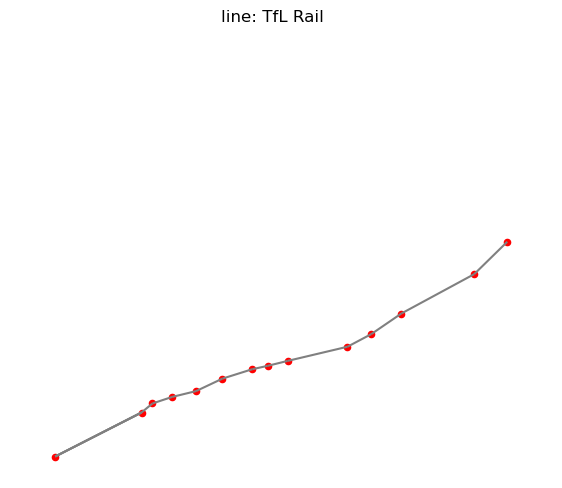

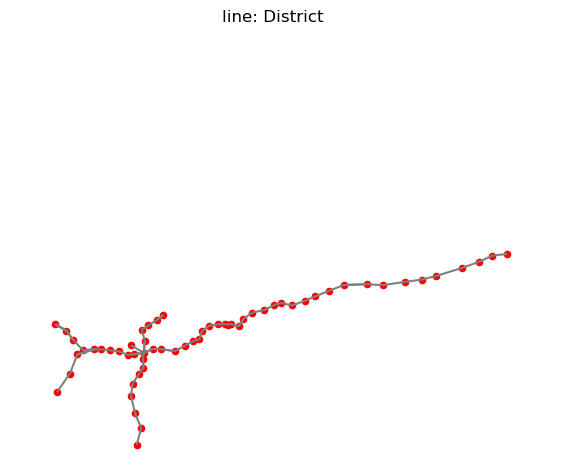

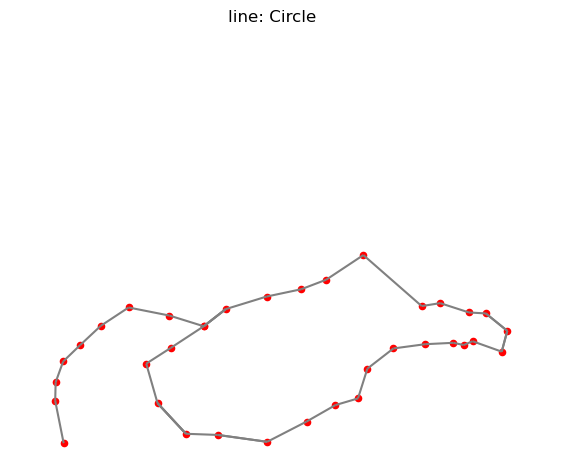

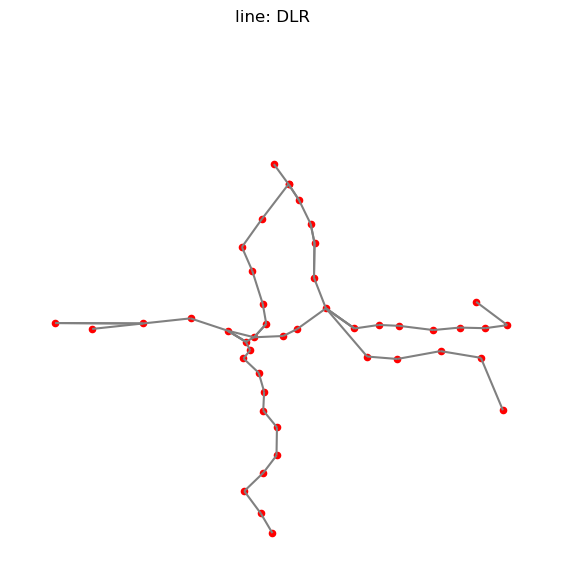

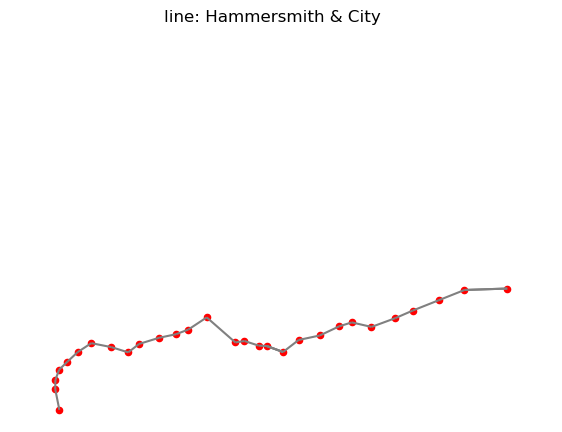

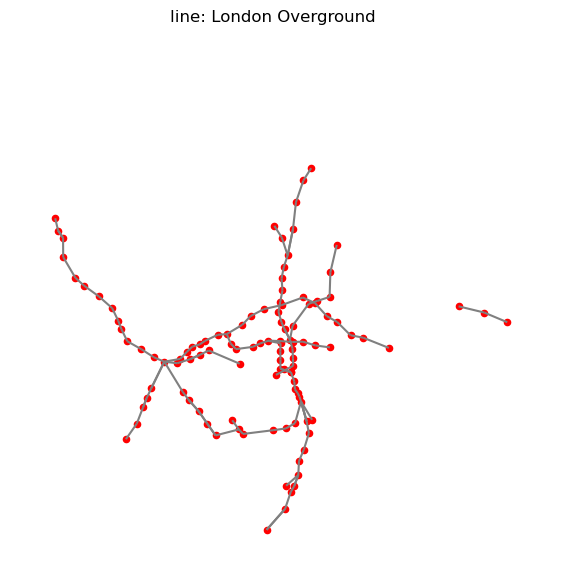

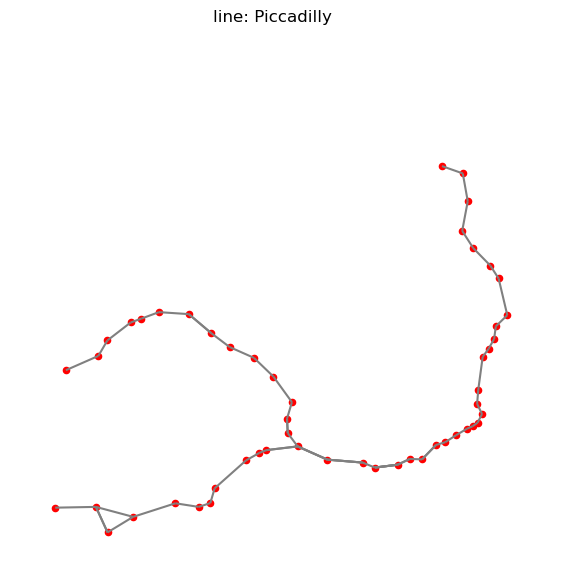

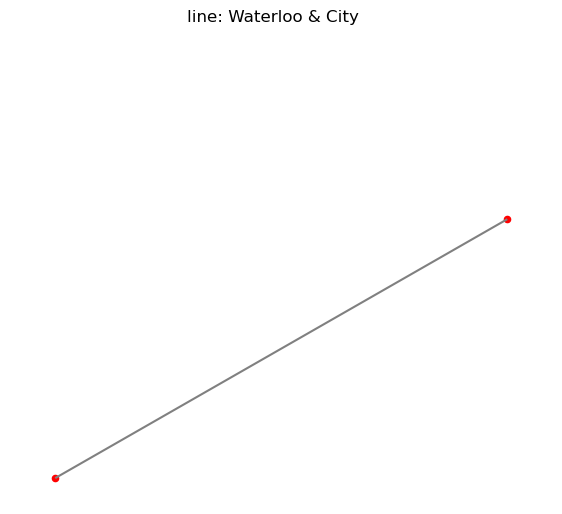

In [42]:
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

<Axes: >

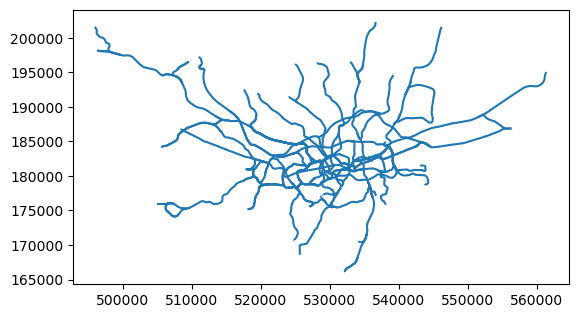

In [43]:
#plot to sanity check
edge_gdf.plot()

In [44]:
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

In [45]:
#this is our resulting dataframe
edge_gdf.head()

,line_name,start_id,end_id,geometry,length
0,Jubilee,940GZZLUWYP,940GZZLUKBY,"LINESTRING (519316.559 186389.330, 519317.885 ...",2916.771558
1,Jubilee,940GZZLUKBY,940GZZLUQBY,"LINESTRING (519359.969 188721.220, 519360.337 ...",1245.995234
2,Jubilee,940GZZLUQBY,940GZZLUCPK,"LINESTRING (518811.361 189760.507, 518812.641 ...",1693.307343
3,Jubilee,940GZZLUCPK,940GZZLUSTM,"LINESTRING (518183.300 191257.263, 518182.820 ...",1419.669476
4,Jubilee,940GZZLUSTD,940GZZLUWHM,"LINESTRING (538524.786 184373.341, 538525.380 ...",1673.509515


In [46]:
#let's replace the ids with the actual name
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

In [47]:
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

In [48]:
edge_gdf.head()

,line_name,start_id,end_id,geometry,length
0,Jubilee,Wembley Park,Kingsbury,"LINESTRING (519316.559 186389.330, 519317.885 ...",2916.771558
1,Jubilee,Kingsbury,Queensbury,"LINESTRING (519359.969 188721.220, 519360.337 ...",1245.995234
2,Jubilee,Queensbury,Canons Park,"LINESTRING (518811.361 189760.507, 518812.641 ...",1693.307343
3,Jubilee,Canons Park,Stanmore,"LINESTRING (518183.300 191257.263, 518182.820 ...",1419.669476
4,Jubilee,Stratford,West Ham,"LINESTRING (538524.786 184373.341, 538525.380 ...",1673.509515


In [49]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

{'TfL Rail', 'Jubilee', 'Central', 'Hammersmith & City', 'District', 'Metropolitan', 'Northern', 'Piccadilly', 'London Overground', 'Circle', 'Bakerloo', 'Victoria', 'DLR', 'Waterloo & City'}


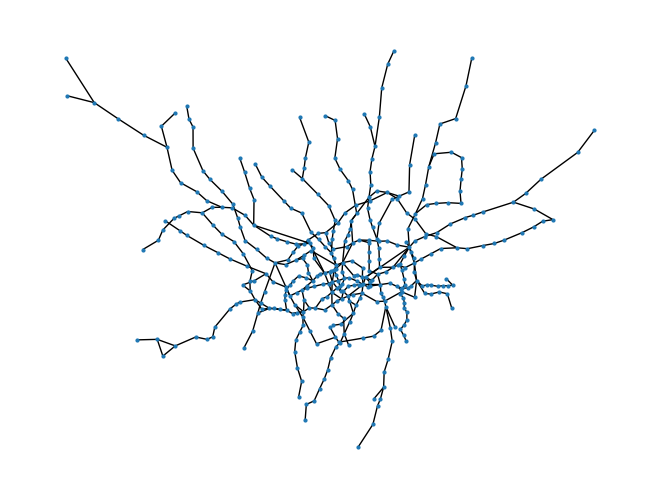

In [50]:
#let's plot
#notice that even though we created the real geometries, the graph still plots just straight line
#this is because networkx doesn't have a concept of a edge geometry
#however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

In [51]:
#save position to graph
nx.set_node_attributes(G, pos, 'coords')

### Sanity check our network

In [52]:
#check that all distances are greater or equal to euclidean distance
for u,v, data in G.edges(data=True):
    assert(data['length'] >= distance.euclidean(pos[u], pos[v]))

In [53]:
#if want to know what is the maximum distance between stations
max(dict(G.edges).items(), key=lambda x: x[1]['length'])

(('Wembley Park', 'Finchley Road'),
 {'length': 7266.373927496486, 'line_name': 'Metropolitan'})

In [54]:
#if want to know to which stations Baker Street is directly connected to
Baker_Street = [(u,v) for  u,v in G.edges() if u == 'Baker Street' or v == 'Baker Street']
Baker_Street

[('Bond Street', 'Baker Street'),
 ('Baker Street', "St. John's Wood"),
 ('Baker Street', 'Great Portland Street'),
 ('Baker Street', 'Finchley Road'),
 ('Baker Street', 'Marylebone'),
 ('Baker Street', "Regent's Park"),
 ('Baker Street', 'Edgware Road')]

In [55]:
#We can also check the degree of the nodes in our network and check that they make sense
deg_london = nx.degree(G)

In [56]:
df = pd.DataFrame(index = dict(deg_london).keys())
df['degree'] = dict(deg_london).values()

In [57]:
df.sort_values('degree', ascending =False).head(20)

,degree
Stratford,9
Bank and Monument,8
Baker Street,7
King's Cross St. Pancras,7
Earl's Court,6
Waterloo,6
Liverpool Street,6
Green Park,6
Canning Town,6
West Ham,6


# Centrality Measures

Calculating three centrality measures for the topological London Underground.

Giving the results in a table for the first 10 ranked nodes for each of the 3 measures.

Here, the networks are supposed to be unweighted so topological betweenesss and closeness centrality measures taken.

Degree, Closeness and Betweenness centrality have been calculated

## Degree Centrality

In [58]:
#  We can calculate the degree centrality using networkx function:
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')

In [59]:
# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
#df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))

df_sorted = df.sort_values(["degree"], ascending=False)
df_sorted[0:10]

,degree
Stratford,0.0225
Bank and Monument,0.0200
Baker Street,0.0175
King's Cross St. Pancras,0.0175
Earl's Court,0.0150
Waterloo,0.0150
Liverpool Street,0.0150
Green Park,0.0150
Canning Town,0.0150
West Ham,0.0150


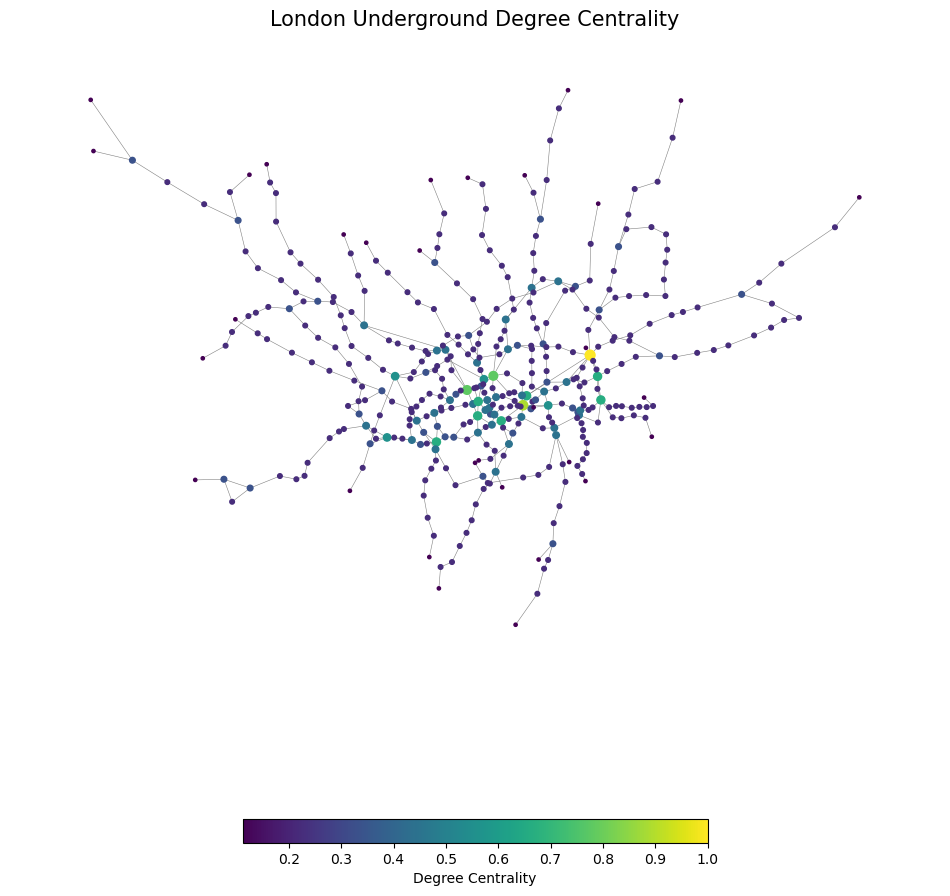

In [60]:
# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['degree']) for i in G.nodes(data=True)]

deg_color=[(i[1]['degree']/(max(degree_values))) for i in G.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G.nodes(data=True)]



# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)

plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London Underground Degree Centrality",fontsize=15)
plt.show()

In [61]:
## Topological Closeness Centrality

In [62]:
#topological closeness centrality
clos_t=nx.closeness_centrality(G)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,clos_t,'closeness_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
#df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['closeness_t'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))

df_sorted = df.sort_values(["closeness_t"], ascending=False)
df_sorted[0:10]

,closeness_t
Green Park,0.114778
Bank and Monument,0.113572
King's Cross St. Pancras,0.113443
Westminster,0.112549
Waterloo,0.112265
Oxford Circus,0.111204
Bond Street,0.110988
Farringdon,0.110742
Angel,0.110742
Moorgate,0.110314


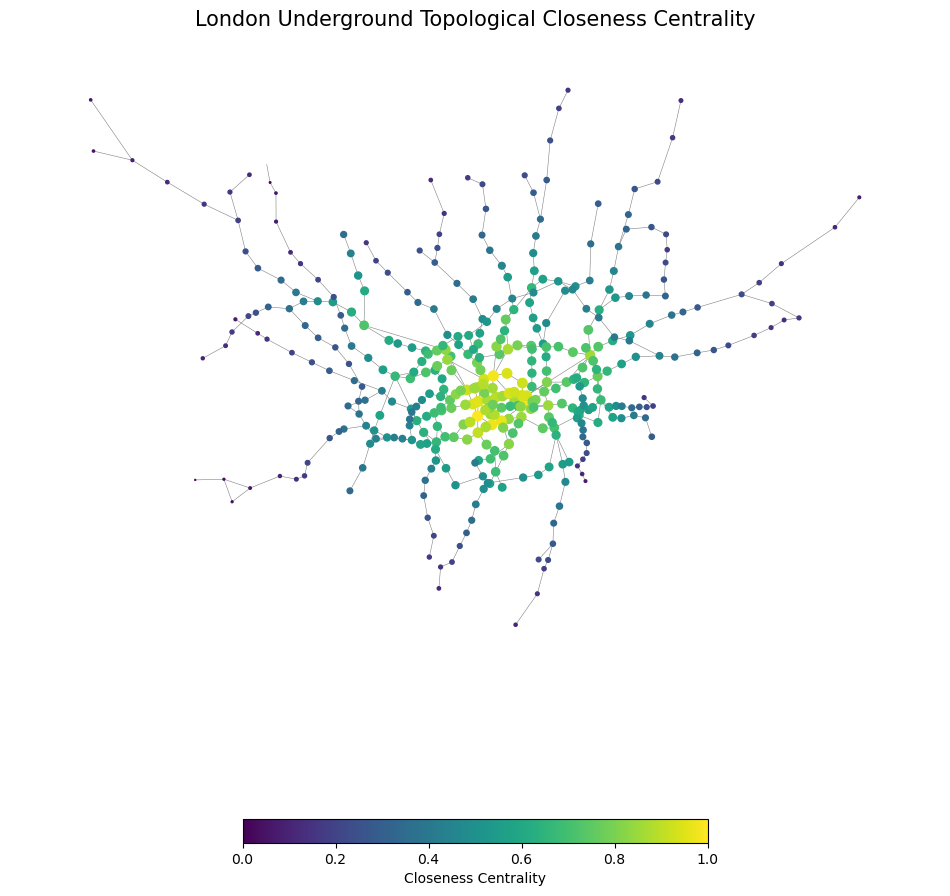

In [63]:
# Lets set color and width of nodes according to the closeness values
clos_t_val=[(i[1]['closeness_t']) for i in G.nodes(data=True)]

closs_t_color=[(i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val)) for i in G.nodes(data=True)]
closs_t_size=[((i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val))*50) for i in G.nodes(data=True)]


# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= closs_t_color,
        node_size= closs_t_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London Underground Topological Closeness Centrality",fontsize=15)
plt.show()

## Betweenness Centrality 

In [64]:
#compute the betweenness centrality for the network, without using weights:
bet_t_val =nx.betweenness_centrality(G, normalized= True)
# add these values to the nodes attributes:
nx.set_node_attributes(G,bet_t_val,'betweenness_t')
# To dataframe using the nodes as the index
bet_t_val_df = pd.DataFrame(index=G.nodes())
# df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
bet_t_val_df['betweenness_t'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))
bet_t_val_df_sorted = bet_t_val_df.sort_values(["betweenness_t"], ascending=False)
bet_t_val_top10 = bet_t_val_df_sorted[0:10]

bet_t_val_top10.reset_index(inplace = True)
bet_t_val_top10.rename(columns = {'index':'Stations'},inplace = True)
bet_t_val_top10

/tmp/ipykernel_67595/851166755.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bet_t_val_top10.rename(columns = {'index':'Stations'},inplace = True)


,Stations,betweenness_t
0,Stratford,0.297846
1,Bank and Monument,0.290489
2,Liverpool Street,0.270807
3,King's Cross St. Pancras,0.255307
4,Waterloo,0.243921
5,Green Park,0.215835
6,Euston,0.208324
7,Westminster,0.203335
8,Baker Street,0.191568
9,Finchley Road,0.165085


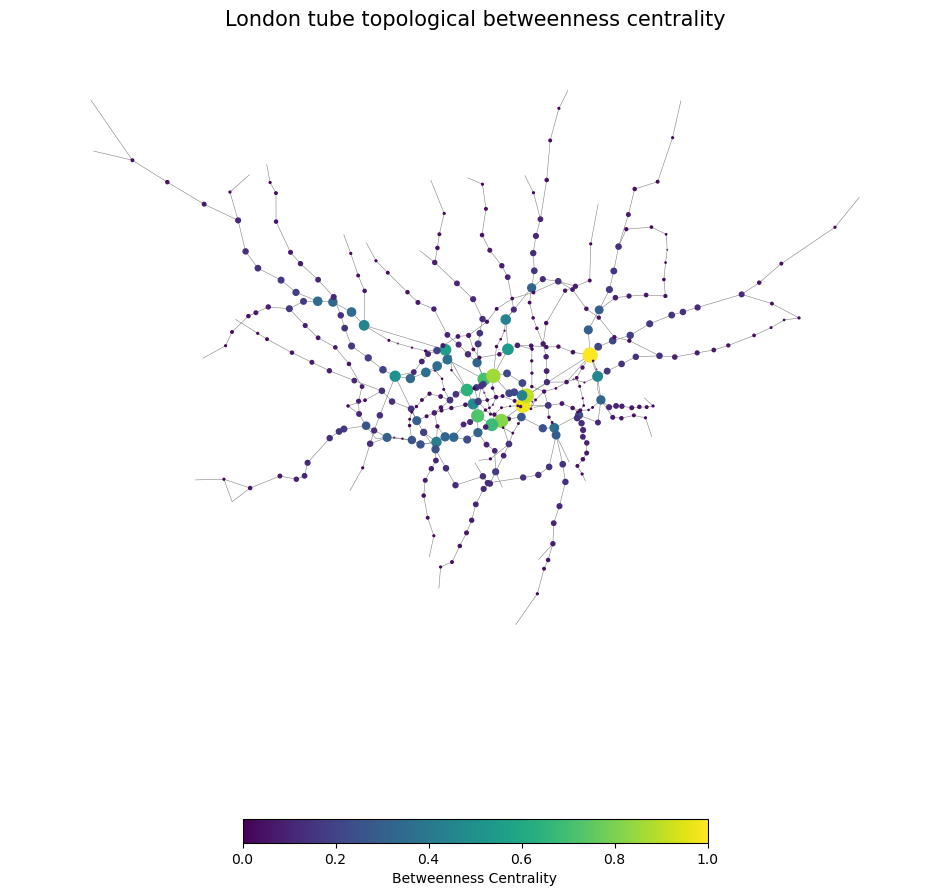

In [65]:
# Lets set colour and size of nodes according to betweenness values
betweenness_t_values=[(i[1]['betweenness_t']) for i in G.nodes(data=True)]

bet_t_color=[(i[1]['betweenness_t']/max(betweenness_t_values)) for i in G.nodes(data=True)]
bet_t_size=[(i[1]['betweenness_t']/max(betweenness_t_values))*100 for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(G, pos = pos, node_color= bet_t_color, node_size= bet_t_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological betweenness centrality",fontsize=15)
plt.show()

# Impact Measures

### Chosen impact measures: largest connected component and global efficiency

## Node Removal

For each of the centrality measures selected in I.1. remove at least 10 nodes following two different strategies.

In [66]:
# defining a function to remove nodes and calculate impact measures

def remove_nodes_and_calculate_measures(G, nodes_to_remove, sequential=False):
    results = []
    Gcopy = G.copy()
    for i, node in enumerate(nodes_to_remove):
        lcc_before = len(max(nx.connected_components(Gcopy), key=len))
        eff_before = nx.global_efficiency(Gcopy)

        Gcopy.remove_node(node)
        
        lcc_after = len(max(nx.connected_components(Gcopy), key=len))
        eff_after = nx.global_efficiency(Gcopy)

        results.append({
            'Removed_node': node,
            'LCC_before': lcc_before,
            'LCC_after': lcc_after,
            'EFF_before': eff_before,
            'EFF_after': eff_after,
            'LCC_change': lcc_before - lcc_after,
            'EFF_change': eff_before - eff_after
        })
        
        if sequential:
            centrality = centrality_measures[centrality_measure_name](Gcopy)
            nodes_to_remove = sorted(centrality, key=centrality.get, reverse=True)
    
    return results

centrality_measures = {
    "degree_centrality": nx.degree_centrality,
    "betweenness_centrality": nx.betweenness_centrality,
    "closeness_centrality": nx.closeness_centrality
}

removal_strategies = ["non-sequential", "sequential"]
num_nodes_to_remove = 10
results = []

for centrality_measure_name, centrality_measure_func in centrality_measures.items():
    for removal_strategy in removal_strategies:
        Gcopy = G.copy()
        centrality = centrality_measure_func(Gcopy)
        sorted_nodes = sorted(centrality, key=centrality.get, reverse=True)[:num_nodes_to_remove]

        result_data = remove_nodes_and_calculate_measures(
            G, sorted_nodes, sequential=(removal_strategy == "sequential")
        )
        for data in result_data:
            data.update({
                'Centrality_measure': centrality_measure_name,
                'Removal_strategy': removal_strategy
            })
        results.extend(result_data)

results_df = pd.DataFrame(results)
results_df.head(60)


,Removed_node,LCC_before,LCC_after,EFF_before,EFF_after,LCC_change,EFF_change,Centrality_measure,Removal_strategy
0,Stratford,401,379,0.101256,0.088917,22,0.012339,degree_centrality,non-sequential
1,Bank and Monument,379,378,0.088917,0.085862,1,0.003056,degree_centrality,non-sequential
2,Baker Street,378,377,0.085862,0.082033,1,0.003828,degree_centrality,non-sequential
3,King's Cross St. Pancras,377,374,0.082033,0.075700,3,0.006333,degree_centrality,non-sequential
4,West Ham,374,371,0.075700,0.073022,3,0.002678,degree_centrality,non-sequential
5,Canning Town,371,356,0.073022,0.068935,15,0.004087,degree_centrality,non-sequential
6,Waterloo,356,355,0.068935,0.067219,1,0.001716,degree_centrality,non-sequential
7,Green Park,355,354,0.067219,0.066221,1,0.000998,degree_centrality,non-sequential
8,Oxford Circus,354,352,0.066221,0.065362,2,0.000859,degree_centrality,non-sequential
9,Liverpool Street,352,346,0.065362,0.063736,6,0.001626,degree_centrality,non-sequential


# Adding Flows to Create A Weighted Network

#### Pre-processing from Week 10 Practical

### Merge Network with OD data

1. add flows as weights to the network (to be able to calculate disruptions to the network)
2. create OD with distance for our spatial interaction models (for our spatial interaction models)

In [67]:
#check that our OD data and network data match
OD_names = set(london_OD_AMpeak.station_origin.unique())
network_names = set([n for n in G.nodes()])

In [68]:
network_names.symmetric_difference(OD_names)

{'Acton Main Line',
 'Battersea Power Station',
 'Hanwell',
 'Hayes & Harlington',
 'Heathrow Terminal 4 EL',
 'Heathrow Terminals 123',
 'Heathrow Terminals 2 & 3',
 'Heathrow Terminals 2 & 3 EL',
 'Nine Elms',
 'Southall',
 "Walthamstow Queen's Road",
 'Walthamstow Queens Road',
 'West Ealing'}

Ok, we have a few stations that don't match up. They are small enough that we can solve this quickly by creating a mapping between names of the stations that we can keep.

* Battersea power station and Nine Elms data doesn't exist in our TFL data because the station wasn't opened when the data was collected. This was an extension of Northern line that opened recently.
* Action Main Line, Hanwell, Hayes & Harlington, Southall, and West Ealing are part of crossrail which we are not considering

In [69]:
#london_OD_AMpeak.station_origin = london_OD_AMpeak.station_origin.apply(
 #   lambda x: name_map[x] if x in name_map.keys() else x
#
#london_OD_AMpeak.station_destination = london_OD_AMpeak.station_destination.apply(
#    lambda x: name_map[x] if x in name_map.keys() else x
#)

In [70]:
#let's filter out the stations that we don't have in our network
OD_names = set(london_OD_AMpeak.station_origin.unique())
_filter = list(network_names.symmetric_difference(OD_names))
_filter

['Southall',
 'Heathrow Terminal 4 EL',
 'Hayes & Harlington',
 'Acton Main Line',
 'Heathrow Terminals 2 & 3 EL',
 'Heathrow Terminals 123',
 'Heathrow Terminals 2 & 3',
 'West Ealing',
 "Walthamstow Queen's Road",
 'Battersea Power Station',
 'Hanwell',
 'Nine Elms',
 'Walthamstow Queens Road']

In [71]:
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_origin.isin(_filter)]
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_destination.isin(_filter)]

**Add flow data to our network**

Our TFL data contains flows for OD pairs, but we don't know the flows passing through each edge in our network. We will have to calculate this assuming fall people travelling from Origin to Destination station are taking the shortest path within the network.

In [72]:
#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

In [73]:
#calculate shortest paths for all flows and add data to dict
for i, row in london_OD_AMpeak.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.flows
        except:
            flows[(v,u)] += row.flows

In [74]:
#set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows')

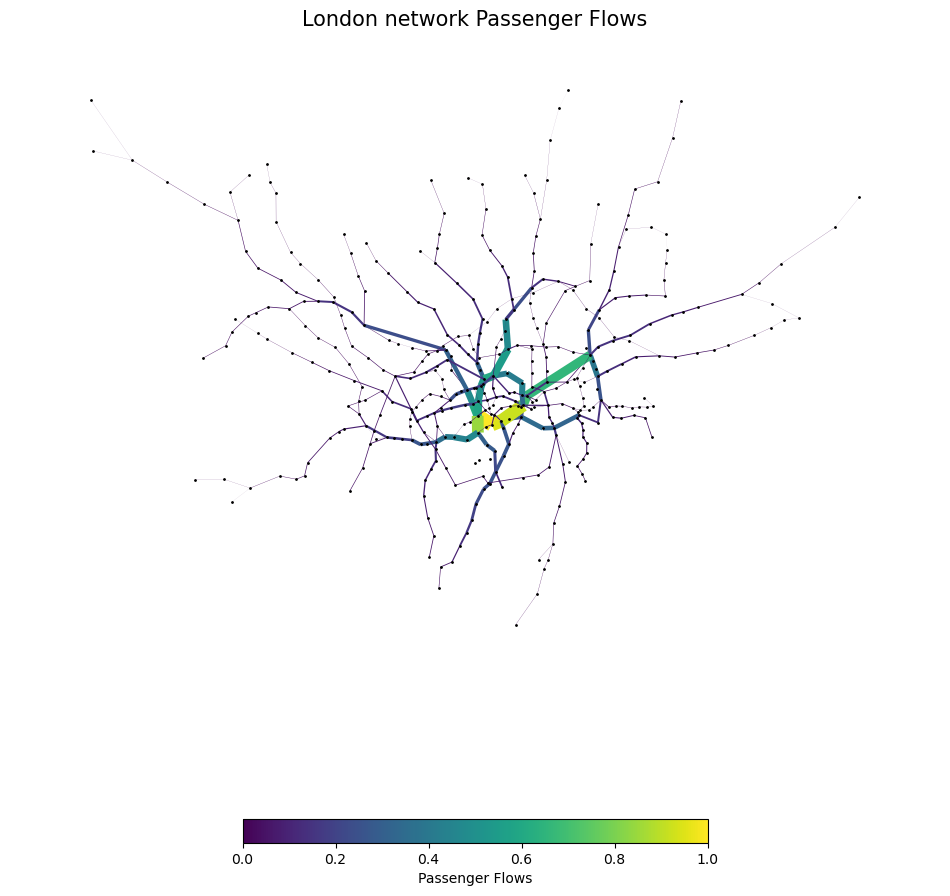

In [75]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

In [76]:
#get edge with highest number of flows
max(flows, key=flows.get)

('Westminster', 'Green Park')

What is going on here? Should we fix it or should we just consider it as a limitation of our model?

In [77]:
#get edge data with lowest number of flows
min(flows, key=flows.get)

('Kennington', 'Nine Elms')

In [78]:
#save graph
for i in G.nodes():
    G.nodes[i]['coords'] = str(G.nodes[i]['coords'])
nx.write_graphml_lxml(G, "outputs/london_updated.graph")

# Weighted Centrality Measures

To answer the question, we only need one centrality measure. This is the one thought best to reflect the importance of a station for the functioning of the underground in section I. 

In [79]:
# find max and min weights
max_weight=max({weight for e1, e2, weight in G.edges(data='flows')})
min_weight=min({weight for e1, e2, weight in G.edges(data='flows')})
max_weight

231711

In [80]:
# inverse weights to prioritise routes with more flows passing through
# higher 
inv_weights={(e1, e2):round(1 - ((weight - min_weight)/ (max_weight - min_weight)),7) for e1, e2, weight in G.edges(data='flows')}
# Let us add the inversed weight as an attribute to the edges in the graph
nx.set_edge_attributes(G, inv_weights, 'inv_weights')

# Print edge list with attributes
list(G.edges(data = True))[0:15]

[('Wembley Park',
  'Kingsbury',
  {'length': 2916.771558050728,
   'line_name': 'Jubilee',
   'flows': 12355,
   'inv_weights': 0.9466793}),
 ('Wembley Park',
  'Neasden',
  {'length': 2353.165938195784,
   'line_name': 'Jubilee',
   'flows': 6744,
   'inv_weights': 0.9708948}),
 ('Wembley Park',
  'Preston Road',
  {'length': 1419.7351657628526,
   'line_name': 'Metropolitan',
   'flows': 36601,
   'inv_weights': 0.8420403}),
 ('Wembley Park',
  'Finchley Road',
  {'length': 7266.373927496486,
   'line_name': 'Metropolitan',
   'flows': 55212,
   'inv_weights': 0.7617204}),
 ('Kingsbury',
  'Queensbury',
  {'length': 1245.995234363654,
   'line_name': 'Jubilee',
   'flows': 9418,
   'inv_weights': 0.9593545}),
 ('Queensbury',
  'Canons Park',
  {'length': 1693.3073431971377,
   'line_name': 'Jubilee',
   'flows': 6385,
   'inv_weights': 0.9724441}),
 ('Canons Park',
  'Stanmore',
  {'length': 1419.669476245658,
   'line_name': 'Jubilee',
   'flows': 3624,
   'inv_weights': 0.9843598}

## Closeness Centrality

In [81]:
#Weighted closeness centrality: 
deg_C_w =nx.closeness_centrality(G, distance='inv_weights')
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,deg_C_w,'closeness_w')

# To dataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['closeness_w'] = pd.Series(nx.get_node_attributes(G, 'closeness_w'))

df_sorted = df.sort_values(["closeness_w"], ascending=False)
df_sorted[0:10]

,closeness_w
Green Park,0.179913
Westminster,0.179913
Waterloo,0.179644
Bank and Monument,0.178957
Victoria,0.177201
Liverpool Street,0.173965
Oxford Circus,0.172853
Bond Street,0.171911
Stratford,0.168400
Sloane Square,0.167736


## Betweenness Centrality 

In [82]:
G6 = G

### Weighted betweenness centrality:
deg_B_w =nx.betweenness_centrality(G6,weight='inv_weights',normalized=True)

# We can add these values to the nodes attributes:
nx.set_node_attributes(G6,deg_B_w,'betweenness_w')

# To dataframe using the nodes as the index
df = pd.DataFrame(index=G6.nodes())
df['betweenness_w'] = pd.Series(nx.get_node_attributes(G6, 'betweenness_w'))

df_sorted = df.sort_values(["betweenness_w"], ascending=False)
df_sorted[0:10]

,betweenness_w
Green Park,0.771046
Westminster,0.662995
Waterloo,0.469276
Bank and Monument,0.462343
Stratford,0.325157
Liverpool Street,0.322162
Euston,0.238280
Victoria,0.218477
Earl's Court,0.214395
Sloane Square,0.209129


## Impact Measures Weighted Network

### weighted global efficiency

In [83]:
# define a function for the weighted global efficiency 
def global_efficiency_weighted(G):
    shortest_paths = dict(nx.shortest_path_length(G, weight='inv_weights'))
    total_efficiency = 0
    n = len(G.nodes())
    valid_pairs = 0
    
    for i in G.nodes():
        for j in G.nodes():
            if i != j and shortest_paths[i][j] != 0:
                total_efficiency += 1 / shortest_paths[i][j]
                valid_pairs += 1

    if valid_pairs == 0:
        return 0
    
    global_efficiency = total_efficiency / (valid_pairs*2)
    return global_efficiency

### Average shortest path lengths

In [84]:
# define a function for the weighted average shorted path length

def average_weighted_shortest_path_length(G):
    shortest_paths = dict(nx.all_pairs_dijkstra_path_length(G, weight='inv_weights'))
    total_path_length = 0
    n = len(G.nodes())
    
    for i in G.nodes():
        for j in G.nodes():
            if i != j:
                total_path_length += shortest_paths[i][j]
    
    average_path_length = total_path_length / (n * (n - 1))
    return average_path_length

## Removing the nodes 

In [85]:
G7= G6.copy()

def remove_highest_betweenness_nodes(G):
    bet_w_values = [(node, data['betweenness_w']) for node, data in G.nodes(data=True)]
    # Find the node(s) with the maximum betweenness centrality
    max_bet_w_value = max(bet_w_values, key=lambda x: x[1])[1]
    maxbet_w = [node for node, bet_w in bet_w_values if bet_w == max_bet_w_value]
    print(f'Removing {maxbet_w}')
    G.remove_nodes_from(maxbet_w)

def update_betweenness(G):
    bet_w = nx.betweenness_centrality(G, weight='inv_weights', normalized=True)
    nx.set_node_attributes(G, bet_w, 'betweenness_w')

def print_node_count(G, phase):
    print(f'{phase} removing, there are {len(G.nodes())} nodes.')

def main(G):
    G7 = G.copy()
    global_efficiencies = [global_efficiency_weighted(G7)]
    efficiency_changes = []

    print_node_count(G7, 'Before')

    for i in range(1, 4):
        remove_highest_betweenness_nodes(G7)
        eff = global_efficiency_weighted(G7)
        global_efficiencies.append(eff)
        efficiency_changes.append(global_efficiencies[-2] - eff)

        print_node_count(G7, 'After')
        print(f'Global efficiency is {eff} after removing.')
        print('---------------------------------------------')
        
        update_betweenness(G7)  

    return global_efficiencies, efficiency_changes

update_betweenness(G7)  # Initialize 'betweenness_w' for all nodes

# Execute the main function with your graph
global_efficiencies, efficiency_changes = main(G7)


Before removing, there are 401 nodes.
Removing ['Green Park']
After removing, there are 400 nodes.
Global efficiency is 0.06245583741034651 after removing.
---------------------------------------------
Removing ["King's Cross St. Pancras"]
After removing, there are 399 nodes.
Global efficiency is 0.05805175126117026 after removing.
---------------------------------------------
Removing ['Bank and Monument']
After removing, there are 398 nodes.
Global efficiency is 0.051191628398753075 after removing.
---------------------------------------------


In [86]:
G7 = G.copy()

# Calculate the initial global efficiency of the network before any node removals
initial_global_efficiency = global_efficiency_weighted(G7)
initial_global_efficiency

0.07013534774546766

### Understand percentage changes

In [87]:
change1 = (0.05905257004842065/0.06497137844036721) * 100
change2 = (0.05288841700804961/0.05905257004842065) * 100
change3 = (0.05004477800766155/0.05288841700804961) * 100

In [88]:
change1

90.89012957085552

In [89]:
change2

89.56158379674807

In [90]:
change3

94.62332366658798

In [91]:
G8= G6.copy()
def remove_max_betweenness_nodes(G):
    bet_w_values = [data['betweenness_w'] for node, data in G.nodes(data=True)]
    max_bet_w = [node for node in G.nodes if G.nodes[node]['betweenness_w'] == max(bet_w_values)]
    print(f"Removing {max_bet_w}")
    G.remove_nodes_from(max_bet_w)

def update_betweenness_weights(G):
    bet_w = nx.betweenness_centrality(G, weight='inv_weights', normalized=True)
    nx.set_node_attributes(G, bet_w, 'betweenness_w')

def main(G):
    average_path = [average_weighted_shortest_path_length(G)]
    diff_avr = []

    for i in range(1, 4):
        print(f"Before removing, there are {len(G.nodes)} nodes.")
        remove_max_betweenness_nodes(G)

        avr = average_weighted_shortest_path_length(G)
        print(f"After removing, there are {len(G.nodes)} nodes.")
        average_path.append(avr)
        diff_avr.append(avr - average_path[i-1])

        print(f"Average shortest path is {avr} after removing.")
        print('---------------------------------------------')

        update_betweenness_weights(G)

# print output
main(G8)

Before removing, there are 401 nodes.
Removing ['Green Park']
After removing, there are 400 nodes.
Average shortest path is 11.09475501233106 after removing.
---------------------------------------------
Before removing, there are 400 nodes.
Removing ["King's Cross St. Pancras"]
After removing, there are 399 nodes.
Average shortest path is 12.022937922662397 after removing.
---------------------------------------------
Before removing, there are 399 nodes.
Removing ['Bank and Monument']
After removing, there are 398 nodes.
Average shortest path is 13.730525941792363 after removing.
---------------------------------------------


Before removing, there are 401 nodes.
Removing ['Green Park']
After removing, there are 400 nodes.
Average shortest path is 11.09475501233106 after removing.
---------------------------------------------
Before removing, there are 400 nodes.
Removing ["King's Cross St. Pancras"]
After removing, there are 399 nodes.
Average shortest path is 12.022937922662397 after removing.
---------------------------------------------
Before removing, there are 399 nodes.
Removing ['Bank and Monument']
After removing, there are 398 nodes.
Average shortest path is 13.730525941792363 after removing.
---------------------------------------------


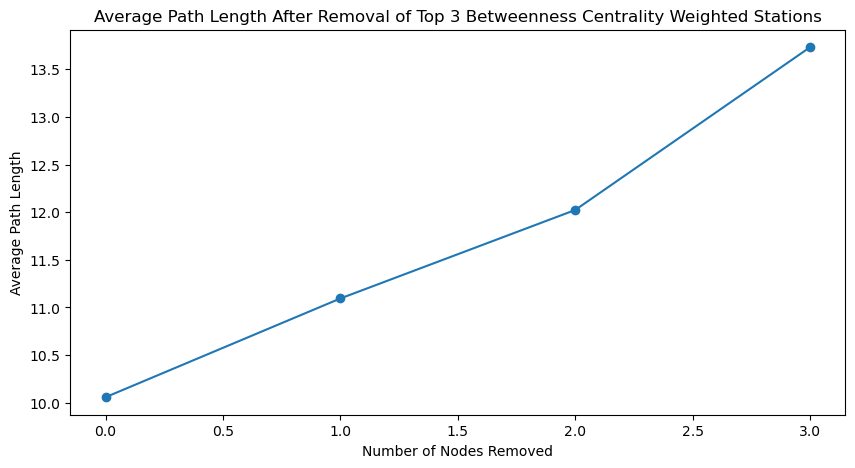

In [92]:
def remove_max_betweenness_nodes(G):
    bet_w_values = [data['betweenness_w'] for node, data in G.nodes(data=True)]
    max_bet_w = [node for node in G.nodes if G.nodes[node]['betweenness_w'] == max(bet_w_values)]
    print(f"Removing {max_bet_w}")
    G.remove_nodes_from(max_bet_w)

def update_betweenness_weights(G):
    bet_w = nx.betweenness_centrality(G, weight='inv_weights', normalized=True)
    nx.set_node_attributes(G, bet_w, 'betweenness_w')

def main(G):
    average_path = [average_weighted_shortest_path_length(G)]
    diff_avr = []

    for i in range(1, 4):
        print(f"Before removing, there are {len(G.nodes)} nodes.")
        remove_max_betweenness_nodes(G)

        avr = average_weighted_shortest_path_length(G)
        print(f"After removing, there are {len(G.nodes)} nodes.")
        average_path.append(avr)
        diff_avr.append(avr - average_path[i-1])

        print(f"Average shortest path is {avr} after removing.")
        print('---------------------------------------------')

        update_betweenness_weights(G)

    # Plotting the average path lengths
    plt.figure(figsize=(10, 5))
    plt.plot(average_path, marker='o')
    plt.title('Average Path Length After Removal of Top 3 Betweenness Centrality Weighted Stations')
    plt.xlabel('Number of Nodes Removed')
    plt.ylabel('Average Path Length')
    plt.savefig('average_path_2', dpi=300)
    plt.show()

# Assuming G8 is defined and ready
G8 = G6.copy()  # Assuming G6 is your original graph
main(G8)

In [93]:
initial_average_path_length = average_weighted_shortest_path_length(G6)
initial_average_path_length

10.05867930519224

### Understand percentage changes

In [94]:
change1 = (11.55775430870925/10.64555110031678) * 100
change2 = (13.286450874181785/11.55775430870925) * 100
change3 = (14.063601947857553/13.286450874181785) * 100

In [95]:
change1

108.56886787538247

In [96]:
change2

114.95702815009565

In [97]:
change3

105.84919991828612

### Plot changes on line graph

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


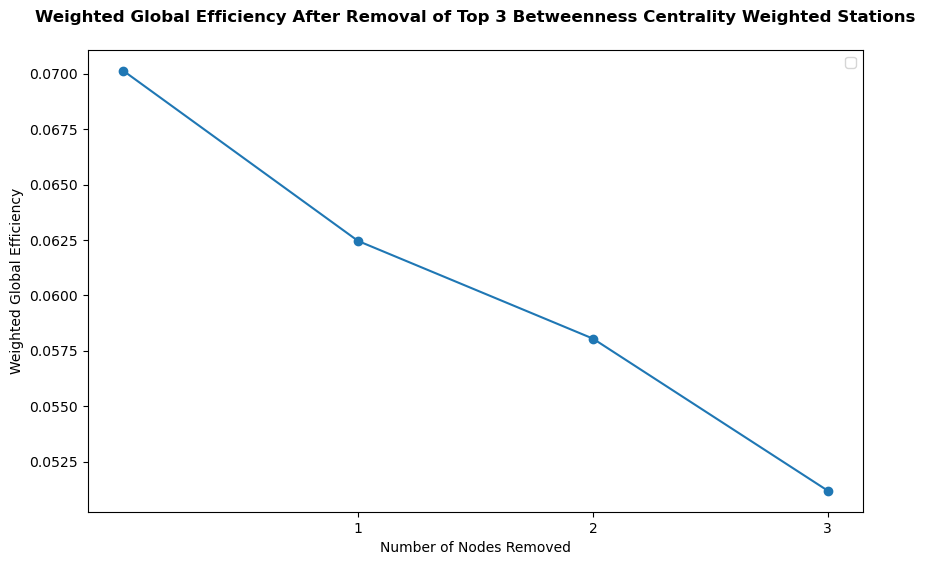

In [98]:
plt.figure(figsize=(10, 6))

plt.plot(global_efficiencies, marker='o',)

plt.legend()
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Weighted Global Efficiency')
plt.title('Weighted Global Efficiency After Removal of Top 3 Betweenness Centrality Weighted Stations', pad=20, fontweight='bold')

# Set x-axis ticks
plt.xticks(range(1, 4, 1))  # Start at 1, end before 4, increment by 1

plt.savefig('weighted_eff.jpg', dpi=300)
# Show the plot
plt.show()


### Rest of the code below is just the remainder of the pre-processing code from week 10 practical

**Create OD pairs with distance, population and jobs**

Lastly for our spatial interaction we need to add distance data to our OD list, as well as population and jobs.
Since we don't have population and jobs data at a station level, we will use total in and out flows as proxies.

In [99]:
#### Create Origin Destination matrix
OD = pd.pivot_table(london_OD_AMpeak, 
                    values ="flows", 
                    index="station_origin", 
                    columns = "station_destination",
                    aggfunc=sum, 
                    margins=True)
OD.fillna(0, inplace=True)
OD = OD.astype(int)
OD.to_csv('outputs/OD_matrix.csv')

/tmp/ipykernel_67595/1830318973.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  OD = pd.pivot_table(london_OD_AMpeak,
/tmp/ipykernel_67595/1830318973.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  OD = pd.pivot_table(london_OD_AMpeak,
/tmp/ipykernel_67595/1830318973.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  OD = pd.pivot_table(london_OD_AMpeak,


In [100]:
OD.sort_values(by='All').tail(10)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Finsbury Park,0,0,19,156,39,0,6,1,0,34,...,16,4,113,18,0,0,0,2,0,24704
Canada Water,0,0,17,0,0,0,5,0,43,81,...,0,1,6,2,0,3,0,4,0,26995
King's Cross St. Pancras,0,0,22,842,160,0,7,2,0,135,...,38,8,71,214,0,3,0,12,0,28205
Bank and Monument,0,0,6,31,250,25,0,0,0,518,...,38,2,31,1,0,10,0,9,509,29478
Liverpool Street,0,0,12,384,150,0,3,3,0,121,...,5,1,15,53,61,12,0,1,0,31455
London Bridge,0,0,24,20,47,0,9,1,0,905,...,0,1,52,1,0,5,0,9,0,32545
Victoria,0,0,30,59,153,0,9,2,0,235,...,53,2,122,2,0,7,0,26,0,37448
Stratford,223,25,7,18,186,157,3,0,0,167,...,3,4,43,1,0,133,0,8,1106,59292
Waterloo,0,0,14,108,381,0,6,1,0,306,...,2,0,43,5,0,12,0,18,0,67337


In [101]:
#lets get total at origin and total at destinations
origin = OD.loc[:,'All'].to_dict()
destination = OD.loc['All',:].to_dict()

In [102]:
#lets add this data as population and jobs
london_OD_AMpeak['population'] = london_OD_AMpeak.station_origin.apply(lambda x: origin[x])
london_OD_AMpeak['jobs'] = london_OD_AMpeak.station_destination.apply(lambda x: destination[x])

In [103]:
#get distance between stations withion the network
london_OD_AMpeak['distance'] = -1
for i, row in london_OD_AMpeak.iterrows():
    source = row.station_origin
    target = row.station_destination
    distance = nx.shortest_path_length(G, source, target, weight='length', method='dijkstra')
    london_OD_AMpeak.loc[i, 'distance'] = distance

# or you could use all_pairs_dijkstra_path_length(G, weight='length') to get all distances at once...

/tmp/ipykernel_67595/4146044356.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8131.525096866283' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  london_OD_AMpeak.loc[i, 'distance'] = distance


In [104]:
london_OD_AMpeak.to_csv('outputs/london_flows.csv', index=False)

There was some confusion about missing potential flows in the network for the assignment. This is how you would do the complete square matrix.

In [105]:
# remove the ALL column and row
OD_melt = OD.iloc[:-1,:-1]
# melt OD back to a long dataframe
OD_melt = OD_melt.reset_index().melt(id_vars='station_origin', value_vars=OD.columns[:-1])
OD_melt.columns = ['station_origin', 'station_destination', 'flows']
# remove the self flows
OD_melt = OD_melt[OD_melt.station_origin != OD_melt.station_destination]
OD_melt.head()


,station_origin,station_destination,flows
1,Acton Central,Abbey Road,0
2,Acton Town,Abbey Road,0
3,Aldgate,Abbey Road,0
4,Aldgate East,Abbey Road,0
5,All Saints,Abbey Road,0


In [106]:
OD_melt['population'] = OD_melt.station_origin.apply(lambda x: origin[x])
OD_melt['jobs'] = OD_melt.station_destination.apply(lambda x: destination[x])

In [107]:
# get distance between stations withion the network
OD_melt['distance'] = -1
for i, row in OD_melt.iterrows():
    source = row.station_origin
    target = row.station_destination
    distance = nx.shortest_path_length(G, source, target, weight='length', method='dijkstra')
    OD_melt.loc[i, 'distance'] = distance

print(OD_melt.shape)
OD_melt.head()

/tmp/ipykernel_67595/1641818707.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '23416.724397305643' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  OD_melt.loc[i, 'distance'] = distance


(157212, 6)


,station_origin,station_destination,flows,population,jobs,distance
1,Acton Central,Abbey Road,0,1224,345,23416.724397
2,Acton Town,Abbey Road,0,3701,345,23638.659673
3,Aldgate,Abbey Road,0,2883,345,7888.981451
4,Aldgate East,Abbey Road,0,3163,345,6452.560669
5,All Saints,Abbey Road,0,740,345,5250.389372


In [108]:
OD_melt.sort_values('flows', ascending=False).head(20)

,station_origin,station_destination,flows,population,jobs,distance
6318,Waterloo,Bank and Monument,15946,67337,78523,2542.954444
22198,Waterloo,Canary Wharf,8085,67337,58743,7433.985750
84490,Stratford,Liverpool Street,6946,59292,61099,6698.461270
22048,London Bridge,Canary Wharf,6165,32545,58743,5679.209735
100002,Victoria,Oxford Circus,5181,37448,44359,2220.166284
21889,Canada Water,Canary Wharf,4030,26995,58743,2601.866276
22161,Stratford,Canary Wharf,3875,59292,58743,5482.674320
47852,Liverpool Street,Farringdon,3755,31455,25589,1602.285759
66423,Finsbury Park,Highbury & Islington,3659,24704,25369,2057.343960
84615,Canada Water,London Bridge,3202,26995,29896,3077.343459


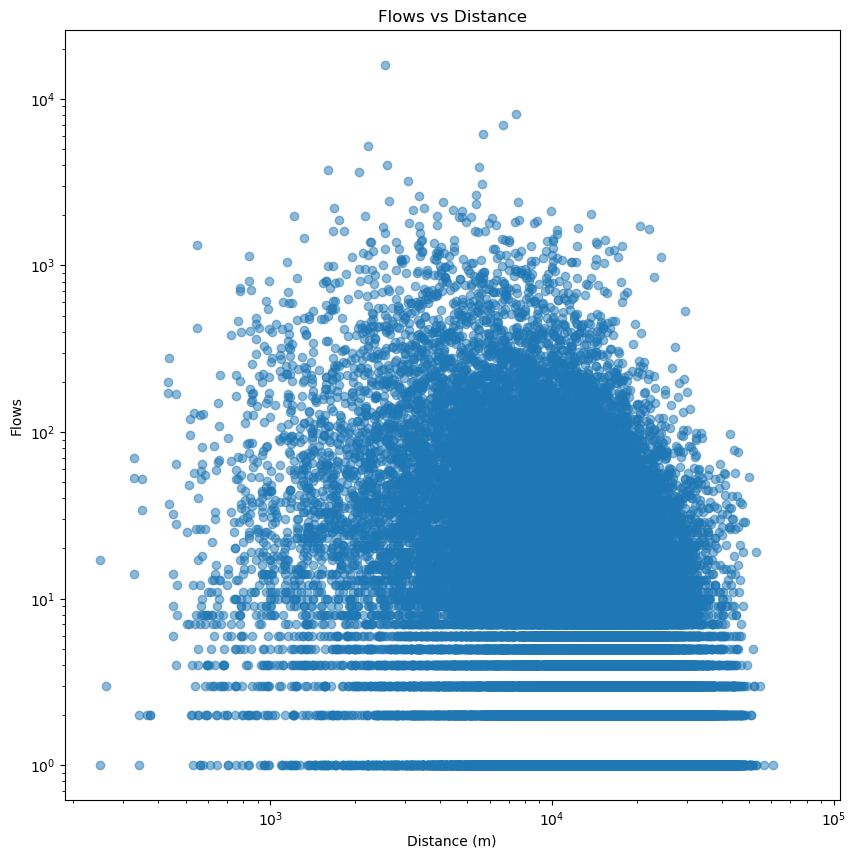

In [109]:
# plot flows against distance, both in the log scale
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(OD_melt.distance, OD_melt.flows, alpha=0.5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Flows')
ax.set_title('Flows vs Distance')

plt.show()